# Long-Short Strategy, Part 3: Evaluating our Boosting Model Signals

In this section, we'll start designing, implementing, and evaluating a trading strategy for US equities driven by daily return forecasts produced by gradient boosting models.

As in the previous examples, we'll lay out a framework and build a specific example that you can adapt to run your own experiments. There are numerous aspects that you can vary, from the asset class and investment universe to more granular aspects like the features, holding period, or trading rules. See, for example, the **Alpha Factor Library** in the [Appendix](../24_alpha_factor_library) for numerous additional features.

We'll keep the trading strategy simple and only use a single ML signal; a real-life application will likely use multiple signals from different sources, such as complementary ML models trained on different datasets or with different lookahead or lookback periods. It would also use sophisticated risk management, from simple stop-loss to value-at-risk analysis.

**Six notebooks** cover our workflow sequence:

1. [preparing_the_model_data](04_preparing_the_model_data.ipyny): we engineer a few simple features from the Quandl Wiki data 
2. [trading_signals_with_lightgbm_and_catboost](05_trading_signals_with_lightgbm_and_catboost.ipynb): we tune hyperparameters for LightGBM and CatBoost to select a model, using 2015/16 as our validation period. 
3. `evaluate_trading_signals` (this noteboook): we compare the cross-validation performance using various metrics to select the best model. 
4. [model_interpretation](07_model_interpretation.ipynb): we take a closer look at the drivers behind the best model's predictions.
5. [making_out_of_sample_predictions](08_making_out_of_sample_predictions.ipynb): we generate predictions for our out-of-sample test period 2017.
6. [backtesting_with_zipline](09_backtesting_with_zipline.ipynb): evaluate the historical performance of a long-short strategy based on our predictive signals using Zipline.

Cross-validation of numerous configurations has produced a large number of results. Now, we need to evaluate the predictive performance to identify the model that generates the most reliable and profitable signals for our prospective trading strategy.

Se toman los daily (en nuestro caso weekly) coeficientes de información, como el mejor indicador y no los totales.

## Imports & Settings

In [116]:
import warnings
warnings.filterwarnings('ignore')

In [117]:
%matplotlib inline

from time import time
from io import StringIO
import sys, os
import warnings
from pathlib import Path
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns

import lightgbm as lgb

from scipy.stats import spearmanr, pearsonr

from alphalens import plotting
from alphalens import performance as perf
from alphalens.utils import get_clean_factor_and_forward_returns, rate_of_return, std_conversion
from alphalens.tears import (create_summary_tear_sheet,
                             create_full_tear_sheet)

In [118]:
sys.path.insert(1, os.path.join(sys.path[0], '..'))
from utils import MultipleTimeSeriesCV

In [119]:
sns.set_style('whitegrid')

In [120]:
#YEAR = 252
#YEAR = 12
idx = pd.IndexSlice

In [121]:
scope_params = ['lookahead', 'train_length', 'test_length']
daily_ic_metrics = ['daily_ic_mean', 'daily_ic_mean_n', 'daily_ic_median', 'daily_ic_median_n']
lgb_train_params = ['learning_rate', 'num_leaves', 'feature_fraction', 'min_data_in_leaf']
rf_train_params = ['bagging_fraction', 'feature_fraction', 'min_data_in_leaf','max_depth']
catboost_train_params = ['max_depth', 'min_child_samples']

In [122]:
results_path = Path('results_trimmed_bien_final_final', 'us_stocks')
if not results_path.exists():
    results_path.mkdir(parents=True)

## Collect Data

We produced a larger number of LightGBM models because it runs an order of magnitude faster than CatBoost and will demonstrate some evaluation strategies accordingly.

### LightGBM

#### Summary Metrics by Fold

First, we collect the summary metrics computed for each fold and hyperparameter combination:

In [123]:
with pd.HDFStore(results_path / 'tuning_lgb.h5') as store:
    for i, key in enumerate(
        [k[1:] for k in store.keys() if k[1:].startswith('metrics')]):
        _, t, train_length, test_length = key.split('/')[:4]
        attrs = {
            'lookahead': t,
            'train_length': train_length,
            'test_length': test_length
        }
        s = store[key].to_dict()
        s.update(attrs)
        if i == 0:
            lgb_metrics = pd.Series(s).to_frame(i)
        else:
            lgb_metrics[i] = pd.Series(s)

id_vars = scope_params + lgb_train_params + daily_ic_metrics
lgb_metrics = pd.melt(lgb_metrics.T.drop('t', axis=1), 
                  id_vars=id_vars, 
                  value_name='ic', 
                  var_name='boost_rounds').dropna().apply(pd.to_numeric)

In [124]:
#print(os.getcwd())

In [125]:
lgb_metrics.to_hdf('data/model_tuning.h5', 'lgb/metrics')
lgb_metrics.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 702 entries, 0 to 701
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   lookahead          702 non-null    int64  
 1   train_length       702 non-null    int64  
 2   test_length        702 non-null    int64  
 3   learning_rate      702 non-null    float64
 4   num_leaves         702 non-null    float64
 5   feature_fraction   702 non-null    float64
 6   min_data_in_leaf   702 non-null    float64
 7   daily_ic_mean      702 non-null    float64
 8   daily_ic_mean_n    702 non-null    float64
 9   daily_ic_median    702 non-null    float64
 10  daily_ic_median_n  702 non-null    float64
 11  boost_rounds       702 non-null    int64  
 12  ic                 702 non-null    float64
dtypes: float64(9), int64(4)
memory usage: 71.4 KB


In [126]:
lgb_metrics.groupby(scope_params).size()

lookahead  train_length  test_length
1          464           1              702
dtype: int64

#### Information Coefficient by Day

Next, we retrieve the IC per day computed during cross-validation:

In [127]:
int_cols = ['lookahead', 'train_length', 'test_length', 'boost_rounds']

In [128]:
lgb_ic = []
with pd.HDFStore(results_path / 'tuning_lgb.h5') as store:
    keys = [k[1:] for k in store.keys()]
    for key in keys:
        _, t, train_length, test_length = key.split('/')[:4]
        if key.startswith('daily_ic'):
            df = (store[key]
                  .drop(['boosting', 'objective', 'verbose'], axis=1)
                 .assign(lookahead=t, 
                         train_length=train_length, 
                         test_length=test_length))
            lgb_ic.append(df)
    lgb_ic = pd.concat(lgb_ic).reset_index()

In [129]:
lgb_ic

date        10        25        50        75       100       150  \
0     2011-01-16  0.358569  0.000000 -0.267307 -0.109091 -0.200000 -0.272727   
1     2011-01-23  0.143019  0.256892  0.354545  0.500000  0.818182  0.636364   
2     2011-01-30 -0.074536 -0.475681 -0.063781 -0.127563 -0.127563 -0.163636   
3     2011-02-06       NaN  0.298142  0.018349  0.063636  0.072727  0.118182   
4     2011-02-13 -0.075434 -0.634525 -0.266066 -0.281818 -0.272727 -0.363636   
...          ...       ...       ...       ...       ...       ...       ...   
25267 2019-12-01  0.525876  0.431211  0.045455  0.036364  0.072727  0.281818   
25268 2019-12-08  0.200000  0.055176  0.609091  0.372727  0.327273  0.390909   
25269 2019-12-15  0.114703  0.036614  0.145786  0.290909  0.181818  0.136364   
25270 2019-12-22  0.300000  0.731229  0.223235 -0.104784 -0.290909 -0.600000   
25271 2019-12-29  0.242914  0.453782  0.410024 -0.209568 -0.327273 -0.354545   

            200       250       300  ...       400       450       500  \
0     -0.245455 -0.354545 -0.436364  ... -0.354545 -0.227273 -0.054545   
1      0.527273  0.336364  0.545455  ...  0.654545  0.700000  0.745455   
2     -0.054545 -0.036364  0.000000  ... -0.072727 -0.127273 -0.090909   
3      0.163636  0.009091 -0.027273  ... -0.045455 -0.072727 -0.045455   
4     -0.418182 -0.372727 -0.427273  ... -0.418182 -0.227273 -0.245455   
...         ...       ...       ...  ...       ...       ...       ...   
25267  0.181818  0.227273  0.127273  ...  0.181818  0.109091  0.145455   
25268  0.409091  0.372727  0.336364  ...  0.454545  0.372727  0.409091   
25269 -0.072727 -0.154545 -0.281818  ... -0.218182 -0.272727 -0.263636   
25270 -0.663636 -0.536364 -0.590909  ... -0.509091 -0.545455 -0.572727   
25271 -0.345455 -0.281818 -0.254545  ... -0.218182  0.072727  0.163636   

       learning_rate  num_leaves  feature_fraction  min_data_in_leaf  \
0               0.30           8              0.95              1000   
1               0.30           8              0.95              1000   
2               0.30           8              0.95              1000   
3               0.30           8              0.95              1000   
4               0.30           8              0.95              1000   
...              ...         ...               ...               ...   
25267           0.01         128              0.30               500   
25268           0.01         128              0.30               500   
25269           0.01         128              0.30               500   
25270           0.01         128              0.30               500   
25271           0.01         128              0.30               500   

       lookahead train_length test_length  
0              1          464           1  
1              1          464           1  
2              1          464           1  
3              1          464           1  
4              1          464           1  
...          ...          ...         ...  
25267          1          464           1  
25268          1          464           1  
25269          1          464           1  
25270          1          464           1  
25271          1          464           1  

[25272 rows x 21 columns]

In [130]:
id_vars

['lookahead',
 'train_length',
 'test_length',
 'learning_rate',
 'num_leaves',
 'feature_fraction',
 'min_data_in_leaf',
 'daily_ic_mean',
 'daily_ic_mean_n',
 'daily_ic_median',
 'daily_ic_median_n']

In [131]:
id_vars = ['date'] + scope_params + lgb_train_params
lgb_ic = pd.melt(lgb_ic, 
                 id_vars=id_vars, 
                 value_name='ic', 
                 var_name='boost_rounds').dropna()
lgb_ic.loc[:, int_cols] = lgb_ic.loc[:, int_cols].astype(int)

In [132]:
lgb_ic.to_hdf('data/model_tuning.h5', 'lgb/ic')
lgb_ic.info()

<class 'pandas.core.frame.DataFrame'>
Index: 317068 entries, 0 to 328535
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   date              317068 non-null  datetime64[ns]
 1   lookahead         317068 non-null  object        
 2   train_length      317068 non-null  object        
 3   test_length       317068 non-null  object        
 4   learning_rate     317068 non-null  float64       
 5   num_leaves        317068 non-null  int64         
 6   feature_fraction  317068 non-null  float64       
 7   min_data_in_leaf  317068 non-null  int64         
 8   boost_rounds      317068 non-null  object        
 9   ic                317068 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(2), object(4)
memory usage: 26.6+ MB


In [133]:
lgb_daily_ic = lgb_ic.groupby(id_vars[1:] + ['boost_rounds']).ic.mean().to_frame('ic').reset_index()
lgb_daily_ic.to_hdf('data/model_tuning.h5', 'lgb/daily_ic')
lgb_daily_ic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 702 entries, 0 to 701
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   lookahead         702 non-null    int64  
 1   train_length      702 non-null    int64  
 2   test_length       702 non-null    int64  
 3   learning_rate     702 non-null    float64
 4   num_leaves        702 non-null    int64  
 5   feature_fraction  702 non-null    float64
 6   min_data_in_leaf  702 non-null    int64  
 7   boost_rounds      702 non-null    int64  
 8   ic                702 non-null    float64
dtypes: float64(3), int64(6)
memory usage: 49.5 KB


In [134]:
lgb_ic = pd.read_hdf('data/model_tuning.h5', 'lgb/ic')
lgb_daily_ic = pd.read_hdf('data/model_tuning.h5', 'lgb/daily_ic')

## Validation Performance: Daily vs Overall Information Coefficient

The following image shows that that LightGBM (in orange) performs (slightly) better than CatBoost, especially for longer horizons. This is not an entirely fair comparison because we ran more configurations for LightGBM, which also, unsurprisingly, shows a wider dispersion of outcomes:


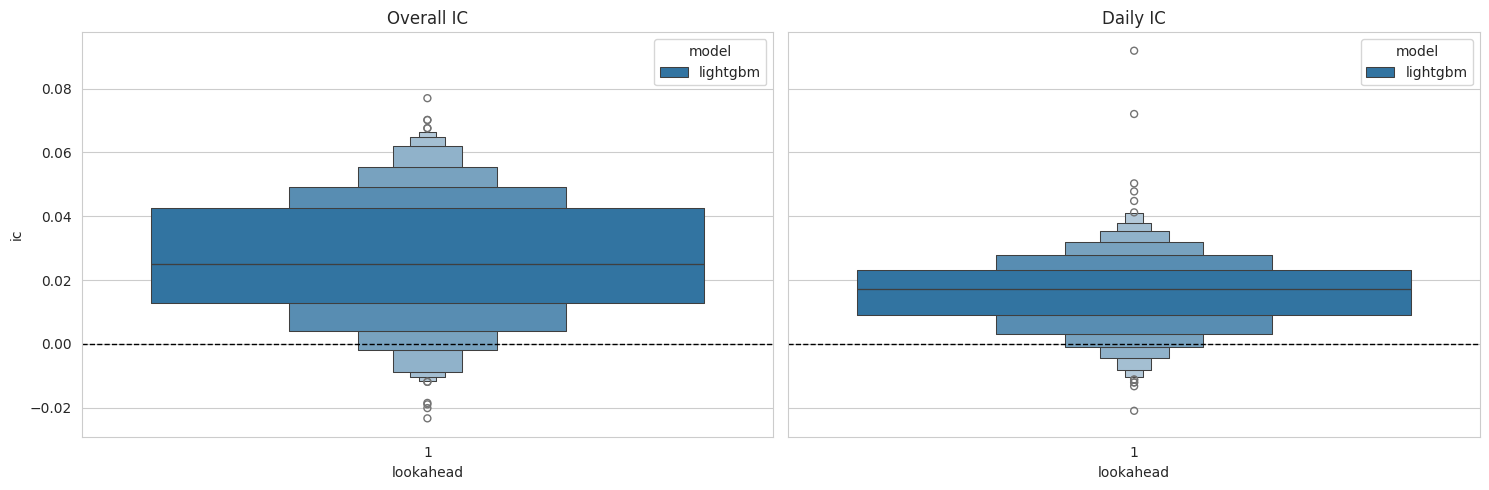

In [150]:
fig, axes = plt.subplots(ncols=2, figsize=(15, 5), sharey=True)
sns.boxenplot(x='lookahead', y='ic', hue='model',
              data=lgb_metrics.assign(model='lightgbm'), ax=axes[0])
axes[0].axhline(0, ls='--', lw=1, c='k')
axes[0].set_title('Overall IC')
sns.boxenplot(x='lookahead', y='ic', hue='model',
              data=lgb_daily_ic.assign(model='lightgbm'), ax=axes[1])
axes[1].axhline(0, ls='--', lw=1, c='k')
axes[1].set_title('Daily IC')
fig.tight_layout()

## Cross-validation Result: Best Hyperparameters

### LightGBM

The top-performing LightGBM models use the following parameters for the three different prediction horizons.

In [158]:
group_cols = scope_params + lgb_train_params + ['boost_rounds']
lgb_daily_ic.groupby('lookahead', group_keys=False).apply(lambda x: x.nlargest(10, 'ic'))

lookahead  train_length  test_length  learning_rate  num_leaves  \
39           1           464            1           0.01           4   
40           1           464            1           0.01           4   
248          1           464            1           0.01         128   
572          1           464            1           0.30           8   
559          1           464            1           0.30           4   
234          1           464            1           0.01         128   
117          1           464            1           0.01           8   
286          1           464            1           0.10           4   
118          1           464            1           0.01           8   
13           1           464            1           0.01           4   

     feature_fraction  min_data_in_leaf  boost_rounds        ic  
39               0.95               500            10  0.091843  
40               0.95               500            25  0.072017  
248              0.95               500            25  0.050283  
572              0.30               250            10  0.047762  
559              0.95              1000            10  0.044768  
234              0.95               250            10  0.041202  
117              0.95               500            10  0.041085  
286              0.60               250            10  0.040700  
118              0.95               500            25  0.040343  
13               0.60               500            10  0.038724

In [159]:
lgb_metrics.groupby('lookahead', group_keys=False).apply(lambda x: x.nlargest(3, 'ic'))
# lgb_metrics.groupby('lookahead', group_keys=False).apply(lambda x: x.nlargest(3, 'ic')).to_csv('results/best_lgb_model.csv', index=False)

lookahead  train_length  test_length  learning_rate  num_leaves  \
4            1           464            1            0.3         4.0   
216          1           464            1            0.3         8.0   
228          1           464            1            0.3       128.0   

     feature_fraction  min_data_in_leaf  daily_ic_mean  daily_ic_mean_n  \
4                0.95            1000.0       0.044768             10.0   
216              0.95            1000.0       0.035092             10.0   
228              0.95            1000.0       0.035092             10.0   

     daily_ic_median  daily_ic_median_n  boost_rounds        ic  
4           0.069584               10.0            10  0.076972  
216         0.064550               10.0           100  0.070146  
228         0.064550               10.0           100  0.070146

In [160]:
lgb_metrics.groupby('lookahead', group_keys=False).apply(lambda x: x.nlargest(10, 'daily_ic_mean'))

lookahead  train_length  test_length  learning_rate  num_leaves  \
39           1           464            1           0.01         4.0   
93           1           464            1           0.01         4.0   
147          1           464            1           0.01         4.0   
201          1           464            1           0.01         4.0   
255          1           464            1           0.01         4.0   
309          1           464            1           0.01         4.0   
363          1           464            1           0.01         4.0   
417          1           464            1           0.01         4.0   
471          1           464            1           0.01         4.0   
525          1           464            1           0.01         4.0   

     feature_fraction  min_data_in_leaf  daily_ic_mean  daily_ic_mean_n  \
39               0.95             500.0       0.091843             10.0   
93               0.95             500.0       0.091843             10.0   
147              0.95             500.0       0.091843             10.0   
201              0.95             500.0       0.091843             10.0   
255              0.95             500.0       0.091843             10.0   
309              0.95             500.0       0.091843             10.0   
363              0.95             500.0       0.091843             10.0   
417              0.95             500.0       0.091843             10.0   
471              0.95             500.0       0.091843             10.0   
525              0.95             500.0       0.091843             10.0   

     daily_ic_median  daily_ic_median_n  boost_rounds        ic  
39          0.093417               10.0            10 -0.002890  
93          0.093417               10.0            25  0.013533  
147         0.093417               10.0            50  0.025613  
201         0.093417               10.0            75  0.028746  
255         0.093417               10.0           100  0.033688  
309         0.093417               10.0           150  0.030882  
363         0.093417               10.0           200  0.028209  
417         0.093417               10.0           250  0.026419  
471         0.093417               10.0           300  0.026788  
525         0.093417               10.0           350  0.027859

### Random Forest

The top-performing RF models use the following parameters for the three different prediction horizons.

In [161]:
# group_cols = scope_params + rf_train_params + ['boost_rounds']
# rf_daily_ic.groupby('lookahead', group_keys=False).apply(lambda x: x.nlargest(10, 'ic'))

In [162]:
# rf_metrics.groupby('lookahead', group_keys=False).apply(lambda x: x.nlargest(3, 'ic'))
# rf_metrics.groupby('lookahead', group_keys=False).apply(lambda x: x.nlargest(3, 'ic')).to_csv('results/best_rf_model.csv', index=False)

In [163]:
# rf_metrics.groupby('lookahead', group_keys=False).apply(lambda x: x.nlargest(10, 'daily_ic_mean'))

sns.jointplot(x=lgb_metrics.daily_ic_mean,y=lgb_metrics.ic);

### Visualization

#### LightGBM

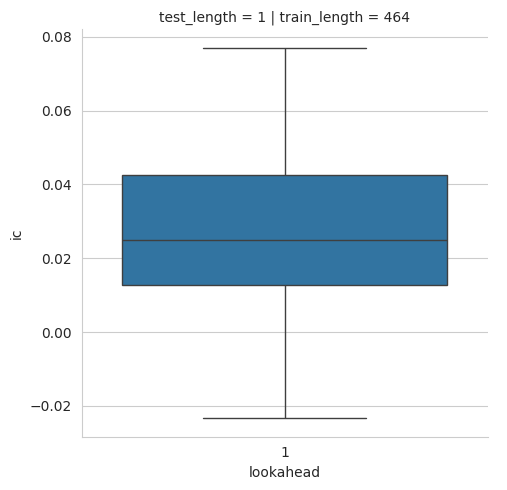

In [164]:
g = sns.catplot(x='lookahead', y='ic',
                col='train_length', row='test_length',
                data=lgb_metrics,
                kind='box')

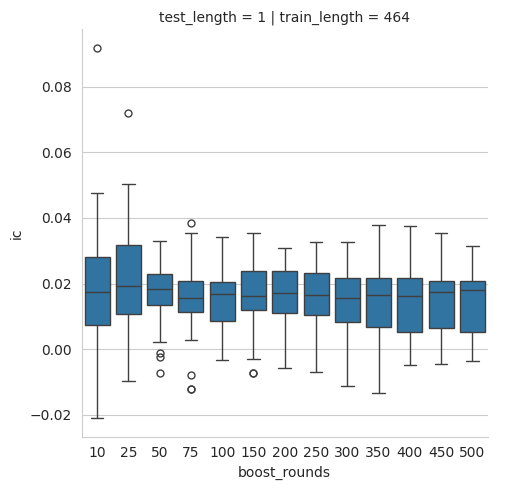

In [165]:
t=1
g=sns.catplot(x='boost_rounds',
            y='ic',
            col='train_length',
            row='test_length',
            data=lgb_daily_ic[lgb_daily_ic.lookahead == t],
            kind='box')

### Random forest

#### Random Forest

Some figures are empty because we did not run those parameter combinations.

In [166]:
# g = sns.catplot(x='lookahead', y='ic',
#                 col='train_length', row='test_length',
#                 data=rf_metrics,
#                 kind='box')

In [167]:
# t=1
# g=sns.catplot(x='boost_rounds',
#             y='ic',
#             col='train_length',
#             row='test_length',
#             data=rf_daily_ic[rf_daily_ic.lookahead == t],
#             kind='box')

The top-performing LightGBM models use the following parameters for the three different prediction horizons.

## AlphaLens Analysis - Validation Performance

### LightGBM

#### Select Parameters

In [168]:
lgb_daily_ic = pd.read_hdf('data/model_tuning.h5', 'lgb/daily_ic')
lgb_daily_ic.info()

<class 'pandas.core.frame.DataFrame'>
Index: 702 entries, 0 to 701
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   lookahead         702 non-null    int64  
 1   train_length      702 non-null    int64  
 2   test_length       702 non-null    int64  
 3   learning_rate     702 non-null    float64
 4   num_leaves        702 non-null    int64  
 5   feature_fraction  702 non-null    float64
 6   min_data_in_leaf  702 non-null    int64  
 7   boost_rounds      702 non-null    int64  
 8   ic                702 non-null    float64
dtypes: float64(3), int64(6)
memory usage: 54.8 KB


In [169]:
def get_lgb_params(data, t=5, best=0):
    param_cols = scope_params[1:] + lgb_train_params + ['boost_rounds']
    df = data[data.lookahead==t].sort_values('ic', ascending=False).iloc[best]
    return df.loc[param_cols]

In [170]:
def get_lgb_key(t, p):
    key = f'{t}/{int(p.train_length)}/{int(p.test_length)}/{p.learning_rate}/'
    return key + f'{int(p.num_leaves)}/{p.feature_fraction}/{int(p.min_data_in_leaf)}'

In [171]:
best_params = get_lgb_params(lgb_daily_ic, t=1, best=0)
best_params

train_length        464.00
test_length           1.00
learning_rate         0.01
num_leaves            4.00
feature_fraction      0.95
min_data_in_leaf    500.00
boost_rounds         10.00
Name: 39, dtype: float64

In [172]:
best_params.to_hdf('data.h5', 'best_params')

#### Plot rolling IC

In [173]:
def select_ic(params, ic_data, lookahead):
    return ic_data.loc[(ic_data.lookahead == lookahead) &
                       (ic_data.train_length == params.train_length) &
                       (ic_data.test_length == params.test_length) &
                       (ic_data.learning_rate == params.learning_rate) &
                       (ic_data.num_leaves == params.num_leaves) &
                       (ic_data.feature_fraction == params.feature_fraction) &
                       (ic_data.boost_rounds == params.boost_rounds), ['date', 'ic']].set_index('date')

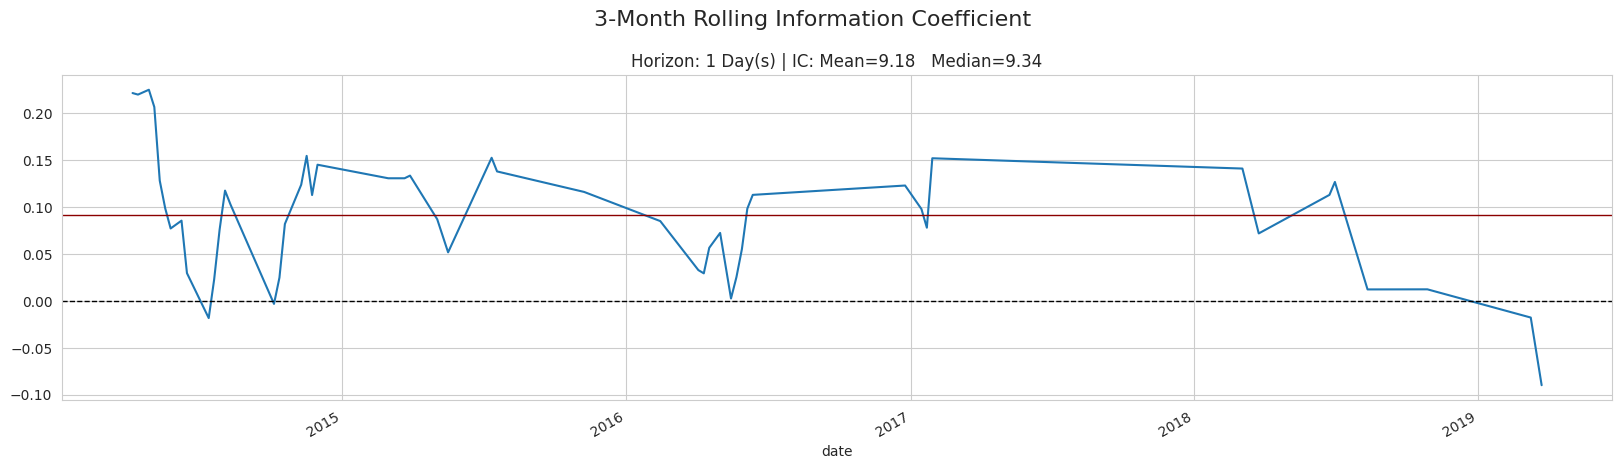

In [174]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(20, 5))
# axes = axes.flatten()


for i, t in enumerate([1]): #modificado para meses un lookahead
    params = get_lgb_params(lgb_daily_ic, t=t)
    data = select_ic(params, lgb_ic, lookahead=t).sort_index()
    #rolling = data.rolling(63).ic.mean().dropna()
    rolling = data.rolling(3*4).ic.mean().dropna()#semanas
    avg = data.ic.mean()
    med = data.ic.median()
    rolling.plot(ax=axes, title=f'Horizon: {t} Day(s) | IC: Mean={avg*100:.2f}   Median={med*100:.2f}')
    axes.axhline(avg, c='darkred', lw=1)
    axes.axhline(0, ls='--', c='k', lw=1)

fig.suptitle('3-Month Rolling Information Coefficient', fontsize=16)
# fig.tight_layout()
fig.subplots_adjust(top=0.85);

In [175]:
t

1

#### Get Predictions for Validation Period

We retrieve the predictions for the 10 validation runs:

In [176]:
lookahead = 1
topn = 10
for best in range(topn):
    best_params = get_lgb_params(lgb_daily_ic, t=lookahead, best=best)
    key = get_lgb_key(lookahead, best_params)
    rounds = str(int(best_params.boost_rounds))
    if best == 0:
        best_predictions = pd.read_hdf(results_path / 'tuning_lgb.h5', 'predictions/' + key)
        best_predictions = best_predictions[rounds].to_frame(best)
    else:
        best_predictions[best] = pd.read_hdf(results_path / 'tuning_lgb.h5',
                                             'predictions/' + key)[rounds]
best_predictions = best_predictions.sort_index()

In [177]:
best_predictions.to_hdf('data/predictions.h5', f'lgb/train/{lookahead:02}')
best_predictions.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 5148 entries, ('IYR', Timestamp('2011-01-16 00:00:00')) to ('XLY', Timestamp('2019-12-29 00:00:00'))
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       5148 non-null   float64
 1   1       5148 non-null   float64
 2   2       5148 non-null   float64
 3   3       5148 non-null   float64
 4   4       5148 non-null   float64
 5   5       5148 non-null   float64
 6   6       5148 non-null   float64
 7   7       5148 non-null   float64
 8   8       5148 non-null   float64
 9   9       5148 non-null   float64
dtypes: float64(10)
memory usage: 460.2+ KB


#### Get Trade Prices

Using next available prices. !! Esta parte del código no está revisada para una adaptacion mensual, no tomar como buena para conclusiones

In [178]:
#modificado
def get_trade_prices(tickers):
    idx = pd.IndexSlice
    DATA_STORE = 'data/assets.h5'
    with pd.HDFStore(DATA_STORE) as store:
        prices = (store['data_close'])  
    display(prices)
    return (prices.loc[idx[tickers, '2012': '2024'], 'open']
            .unstack('ticker')
            .sort_index()
            .shift(-1)
            .tz_localize('UTC')
            .resample('W').last())

In [179]:
test_tickers = best_predictions.index.get_level_values('ticker').unique()#modificado

In [180]:
trade_prices = get_trade_prices(test_tickers)
trade_prices.info()

open        high         low       close     volume  \
ticker date                                                                    
IYR    2000-01-03   19.267872   19.267872   18.455524   18.582453  1185699.0   
       2000-01-04   18.176279   18.201666   17.605097   17.770105   885705.0   
       2000-01-05   17.770105   17.960501   17.440088   17.630484   717181.0   
       2000-01-06   17.681255   18.518990   17.681255   18.404753   415832.0   
       2000-01-07   18.531681   18.734768   18.277822   18.709383   468149.0   
...                       ...         ...         ...         ...        ...   
XLY    2024-12-06  229.860001  232.850006  229.839996  232.800003  2444600.0   
       2024-12-09  234.139999  235.570007  231.229996  232.059998  3256900.0   
       2024-12-10  232.100006  234.600006  231.669998  232.440002  3815400.0   
       2024-12-11  234.369995  236.600006  234.240005  236.520004  2867400.0   
       2024-12-12  236.399994  236.660004  234.270004  234.559998  2433399.0   

                    Adj Close  
ticker date                    
IYR    2000-01-03   11.351279  
       2000-01-04   10.855049  
       2000-01-05   10.769757  
       2000-01-06   11.242723  
       2000-01-07   11.428815  
...                       ...  
XLY    2024-12-06  232.800003  
       2024-12-09  232.059998  
       2024-12-10  232.440002  
       2024-12-11  236.520004  
       2024-12-12  234.559998  

[69047 rows x 6 columns]

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 676 entries, 2012-01-08 00:00:00+00:00 to 2024-12-15 00:00:00+00:00
Freq: W-SUN
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   IYR     676 non-null    float64
 1   VOX     676 non-null    float64
 2   XLB     676 non-null    float64
 3   XLE     676 non-null    float64
 4   XLF     676 non-null    float64
 5   XLI     676 non-null    float64
 6   XLK     676 non-null    float64
 7   XLP     676 non-null    float64
 8   XLU     676 non-null    float64
 9   XLV     676 non-null    float64
 10  XLY     676 non-null    float64
dtypes: float64(11)
memory usage: 63.4 KB


In [181]:
# persist result in case we want to rerun:
trade_prices.to_hdf('data/model_tuning.h5', 'trade_prices/model_selection')
trade_prices = pd.read_hdf('data/model_tuning.h5', 'trade_prices/model_selection')

In [182]:
trade_prices.tail()

ticker                            IYR         VOX        XLB        XLE  \
date                                                                      
2024-11-17 00:00:00+00:00   97.389999  151.139999  91.449997  95.480003   
2024-11-24 00:00:00+00:00  100.940002  153.770004  94.470001  97.250000   
2024-12-01 00:00:00+00:00  101.849998  155.529999  94.879997  95.500000   
2024-12-08 00:00:00+00:00   99.820000  161.000000  92.639999  91.779999   
2024-12-15 00:00:00+00:00   98.019997  163.550003  90.309998  90.239998   

ticker                           XLF         XLI         XLK        XLP  \
date                                                                      
2024-11-17 00:00:00+00:00  49.910000  139.089996  228.710007  80.139999   
2024-11-24 00:00:00+00:00  51.009998  143.380005  235.360001  82.379997   
2024-12-01 00:00:00+00:00  51.419998  143.899994  233.899994  83.139999   
2024-12-08 00:00:00+00:00  50.439999  140.589996  239.940002  82.500000   
2024-12-15 00:00:00+00:00  49.930000  138.750000  237.839996  82.529999   

ticker                           XLU         XLV         XLY  
date                                                          
2024-11-17 00:00:00+00:00  79.180000  141.470001  216.009995  
2024-11-24 00:00:00+00:00  82.099998  144.809998  220.699997  
2024-12-01 00:00:00+00:00  82.919998  147.320007  223.869995  
2024-12-08 00:00:00+00:00  79.690002  144.419998  234.139999  
2024-12-15 00:00:00+00:00  78.000000  142.169998  236.399994

We average the top five models and provide the corresponding prices to Alphalens, in order to compute the mean period-wise return earned on an equal-weighted portfolio invested in the daily factor quintiles for various holding periods:

In [183]:
factor = best_predictions.iloc[:, :5].mean(1).dropna().tz_localize('UTC', level='date').swaplevel()

In [184]:
factor.tail()

date                       ticker
2019-12-01 00:00:00+00:00  XLY       0.004754
2019-12-08 00:00:00+00:00  XLY       0.067746
2019-12-15 00:00:00+00:00  XLY       0.085822
2019-12-22 00:00:00+00:00  XLY       0.053618
2019-12-29 00:00:00+00:00  XLY       0.074426
dtype: float64

In [185]:
#trade_prices= trade_prices.asfreq('W')

In [186]:
trade_prices.tail()

ticker                            IYR         VOX        XLB        XLE  \
date                                                                      
2024-11-17 00:00:00+00:00   97.389999  151.139999  91.449997  95.480003   
2024-11-24 00:00:00+00:00  100.940002  153.770004  94.470001  97.250000   
2024-12-01 00:00:00+00:00  101.849998  155.529999  94.879997  95.500000   
2024-12-08 00:00:00+00:00   99.820000  161.000000  92.639999  91.779999   
2024-12-15 00:00:00+00:00   98.019997  163.550003  90.309998  90.239998   

ticker                           XLF         XLI         XLK        XLP  \
date                                                                      
2024-11-17 00:00:00+00:00  49.910000  139.089996  228.710007  80.139999   
2024-11-24 00:00:00+00:00  51.009998  143.380005  235.360001  82.379997   
2024-12-01 00:00:00+00:00  51.419998  143.899994  233.899994  83.139999   
2024-12-08 00:00:00+00:00  50.439999  140.589996  239.940002  82.500000   
2024-12-15 00:00:00+00:00  49.930000  138.750000  237.839996  82.529999   

ticker                           XLU         XLV         XLY  
date                                                          
2024-11-17 00:00:00+00:00  79.180000  141.470001  216.009995  
2024-11-24 00:00:00+00:00  82.099998  144.809998  220.699997  
2024-12-01 00:00:00+00:00  82.919998  147.320007  223.869995  
2024-12-08 00:00:00+00:00  79.690002  144.419998  234.139999  
2024-12-15 00:00:00+00:00  78.000000  142.169998  236.399994

In [187]:
freq = pd.infer_freq(trade_prices.index)
print(freq)

W-SUN


In [188]:
factor

date                       ticker
2011-01-16 00:00:00+00:00  IYR       0.042254
2011-01-23 00:00:00+00:00  IYR       0.123222
2011-01-30 00:00:00+00:00  IYR       0.057494
2011-02-06 00:00:00+00:00  IYR      -0.027992
2011-02-13 00:00:00+00:00  IYR      -0.028332
                                       ...   
2019-12-01 00:00:00+00:00  XLY       0.004754
2019-12-08 00:00:00+00:00  XLY       0.067746
2019-12-15 00:00:00+00:00  XLY       0.085822
2019-12-22 00:00:00+00:00  XLY       0.053618
2019-12-29 00:00:00+00:00  XLY       0.074426
Length: 5148, dtype: float64

In [189]:
trade_prices

ticker                            IYR         VOX        XLB        XLE  \
date                                                                      
2012-01-08 00:00:00+00:00   56.930000   61.500000  34.820000  70.589996   
2012-01-15 00:00:00+00:00   58.220001   63.160000  36.540001  70.220001   
2012-01-22 00:00:00+00:00   59.119999   63.180000  36.639999  71.629997   
2012-01-29 00:00:00+00:00   60.259998   61.320000  36.619999  70.660004   
2012-02-05 00:00:00+00:00   61.880001   63.310001  37.599998  72.360001   
...                               ...         ...        ...        ...   
2024-11-17 00:00:00+00:00   97.389999  151.139999  91.449997  95.480003   
2024-11-24 00:00:00+00:00  100.940002  153.770004  94.470001  97.250000   
2024-12-01 00:00:00+00:00  101.849998  155.529999  94.879997  95.500000   
2024-12-08 00:00:00+00:00   99.820000  161.000000  92.639999  91.779999   
2024-12-15 00:00:00+00:00   98.019997  163.550003  90.309998  90.239998   

ticker                           XLF         XLI         XLK        XLP  \
date                                                                      
2012-01-08 00:00:00+00:00  10.926076   34.689999   26.059999  32.240002   
2012-01-15 00:00:00+00:00  11.234768   35.970001   26.260000  32.410000   
2012-01-22 00:00:00+00:00  11.494720   36.099998   26.840000  32.310001   
2012-01-29 00:00:00+00:00  11.348497   36.130001   26.670000  32.080002   
2012-02-05 00:00:00+00:00  11.900894   37.000000   27.639999  32.410000   
...                              ...         ...         ...        ...   
2024-11-17 00:00:00+00:00  49.910000  139.089996  228.710007  80.139999   
2024-11-24 00:00:00+00:00  51.009998  143.380005  235.360001  82.379997   
2024-12-01 00:00:00+00:00  51.419998  143.899994  233.899994  83.139999   
2024-12-08 00:00:00+00:00  50.439999  140.589996  239.940002  82.500000   
2024-12-15 00:00:00+00:00  49.930000  138.750000  237.839996  82.529999   

ticker                           XLU         XLV         XLY  
date                                                          
2012-01-08 00:00:00+00:00  35.130001   35.200001   40.160000  
2012-01-15 00:00:00+00:00  35.090000   35.709999   40.610001  
2012-01-22 00:00:00+00:00  34.560001   35.860001   41.169998  
2012-01-29 00:00:00+00:00  34.599998   35.599998   41.090000  
2012-02-05 00:00:00+00:00  34.779999   36.060001   41.990002  
...                              ...         ...         ...  
2024-11-17 00:00:00+00:00  79.180000  141.470001  216.009995  
2024-11-24 00:00:00+00:00  82.099998  144.809998  220.699997  
2024-12-01 00:00:00+00:00  82.919998  147.320007  223.869995  
2024-12-08 00:00:00+00:00  79.690002  144.419998  234.139999  
2024-12-15 00:00:00+00:00  78.000000  142.169998  236.399994  

[676 rows x 11 columns]

#### Create AlphaLens Inputs

In [190]:
factor_data = get_clean_factor_and_forward_returns(factor=factor,
                                                   prices=trade_prices,
                                                   quantiles=5,
                                                   #periods=(1, 2))#modificado
                                                   periods=(1,2),max_loss=2)#modificado

Dropped 66.7% entries from factor data: 10.9% in forward returns computation and 55.8% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 200.0%, not exceeded: OK!


In [191]:
factor_data

1D        2D    factor  factor_quantile
date                      asset                                               
2012-01-29 00:00:00+00:00 IYR    0.026884  0.016927 -0.092846              1.0
2012-03-11 00:00:00+00:00 IYR    0.026259  0.019818  0.031585              4.0
2012-03-25 00:00:00+00:00 IYR    0.008097 -0.017004  0.103981              1.0
2012-04-15 00:00:00+00:00 IYR    0.012066  0.041741 -0.097352              3.0
2012-05-06 00:00:00+00:00 IYR   -0.001732 -0.057462 -0.072255              2.0
...                                   ...       ...       ...              ...
2018-11-18 00:00:00+00:00 XLY   -0.026480  0.038541  0.168702              3.0
2019-01-27 00:00:00+00:00 XLY    0.010002  0.014248  0.003125              1.0
2019-03-10 00:00:00+00:00 XLY    0.017191  0.024361  0.243654              4.0
2019-07-14 00:00:00+00:00 XLY   -0.015923 -0.008926  0.110881              1.0
2019-08-18 00:00:00+00:00 XLY   -0.000936  0.013023  0.058668              3.0

[1716 rows x 4 columns]

#### Compute Alphalens metrics

In [192]:
mean_quant_ret_bydate, std_quant_daily = perf.mean_return_by_quantile(
    factor_data,
    by_date=True,
    by_group=False,
    demeaned=True,
    group_adjust=False,
)

In [193]:
factor_returns = perf.factor_returns(factor_data)

In [194]:
mean_quant_ret, std_quantile = perf.mean_return_by_quantile(factor_data,
                                                            by_group=False,
                                                            demeaned=True)



mean_quant_rateret = mean_quant_ret.apply(rate_of_return, axis=0,
                                          base_period=mean_quant_ret.columns[0])

In [195]:
import numpy as np

# Reemplazar infinitos con la media de cada columna numérica
numeric_cols = factor_data.select_dtypes(include=np.number).columns
for col in numeric_cols:
    mask = np.isinf(factor_data[col])
    factor_data.loc[mask, col] = factor_data[col].replace([np.inf, -np.inf], np.nan).mean()

print("Number of NaN values in factor_data:")
print(factor_data.isna().sum())
print("\nTotal NaN values:", factor_data.isna().sum().sum())
print("\nNumber of infinite values:", np.isinf(factor_data.select_dtypes(include=np.number)).sum().sum())
print("\nShape of factor_data:", factor_data.shape)
print("\nSample of factor_data:")
factor_data

Number of NaN values in factor_data:
1D                 0
2D                 0
factor             0
factor_quantile    0
dtype: int64

Total NaN values: 0

Number of infinite values: 0

Shape of factor_data: (1716, 4)

Sample of factor_data:


1D        2D    factor  factor_quantile
date                      asset                                               
2012-01-29 00:00:00+00:00 IYR    0.026884  0.016927 -0.092846              1.0
2012-03-11 00:00:00+00:00 IYR    0.026259  0.019818  0.031585              4.0
2012-03-25 00:00:00+00:00 IYR    0.008097 -0.017004  0.103981              1.0
2012-04-15 00:00:00+00:00 IYR    0.012066  0.041741 -0.097352              3.0
2012-05-06 00:00:00+00:00 IYR   -0.001732 -0.057462 -0.072255              2.0
...                                   ...       ...       ...              ...
2018-11-18 00:00:00+00:00 XLY   -0.026480  0.038541  0.168702              3.0
2019-01-27 00:00:00+00:00 XLY    0.010002  0.014248  0.003125              1.0
2019-03-10 00:00:00+00:00 XLY    0.017191  0.024361  0.243654              4.0
2019-07-14 00:00:00+00:00 XLY   -0.015923 -0.008926  0.110881              1.0
2019-08-18 00:00:00+00:00 XLY   -0.000936  0.013023  0.058668              3.0

[1716 rows x 4 columns]

In [196]:
mean_quant_ret_bydate, std_quant_daily = perf.mean_return_by_quantile(
    factor_data,
    by_date=True,
    by_group=False,
    demeaned=True,
    group_adjust=False,
)

mean_quant_rateret_bydate = mean_quant_ret_bydate.apply(
    rate_of_return,
    base_period=mean_quant_ret_bydate.columns[0],
)

compstd_quant_daily = std_quant_daily.apply(std_conversion,
                                            base_period=std_quant_daily.columns[0])

alpha_beta = perf.factor_alpha_beta(factor_data,
                                    demeaned=True)

mean_ret_spread_quant, std_spread_quant = perf.compute_mean_returns_spread(
    mean_quant_rateret_bydate,
    factor_data["factor_quantile"].max(),
    factor_data["factor_quantile"].min(),
    std_err=compstd_quant_daily,
)

In [197]:
mean_ret_spread_quant.mean().mul(10000).to_frame('Mean Period Wise Spread (bps)').join(alpha_beta.T).T

1D         2D
Mean Period Wise Spread (bps)  30.602520  17.908110
Ann. alpha                      0.407483   0.236533
beta                            0.042618  -0.003893

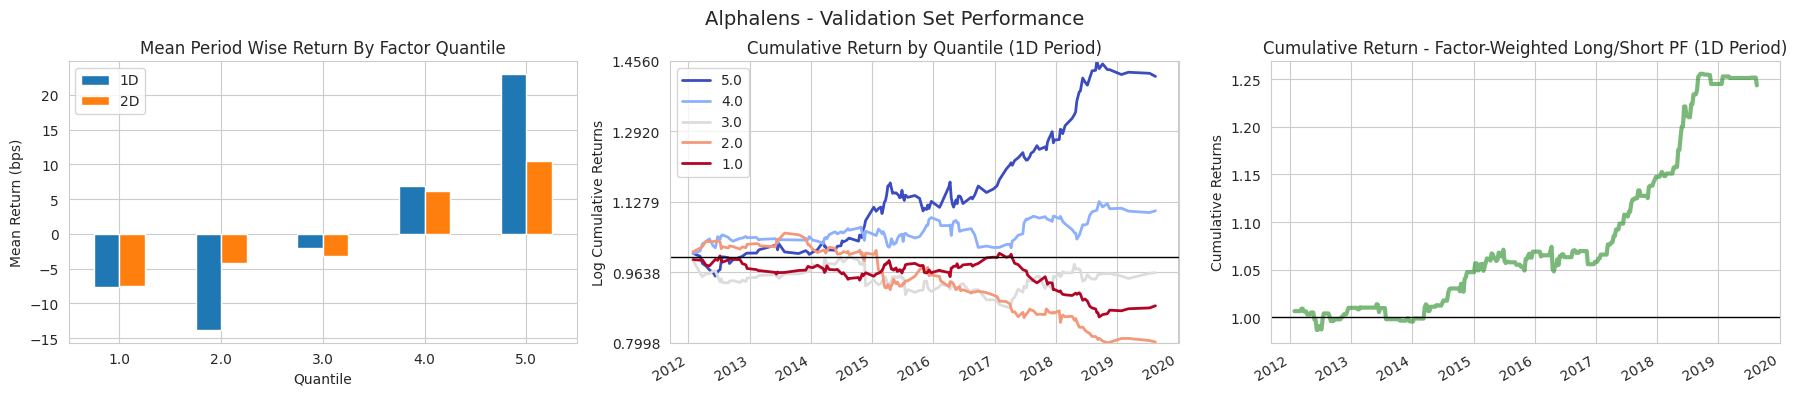

In [198]:
fig, axes = plt.subplots(ncols=3, figsize=(18, 4))


plotting.plot_quantile_returns_bar(mean_quant_rateret, ax=axes[0])
plt.setp(axes[0].xaxis.get_majorticklabels(), rotation=0)
axes[0].set_xlabel('Quantile')

plotting.plot_cumulative_returns_by_quantile(mean_quant_ret_bydate['1D'],
                                             freq=pd.tseries.offsets.BDay(),
                                             period='1D',
                                             ax=axes[1])
axes[1].set_title('Cumulative Return by Quantile (1D Period)')

title = "Cumulative Return - Factor-Weighted Long/Short PF (1D Period)"
plotting.plot_cumulative_returns(factor_returns['1D'],
                                 period='1D',
                                 freq=pd.tseries.offsets.BDay(),
                                 title=title,
                                 ax=axes[2])

fig.suptitle('Alphalens - Validation Set Performance', fontsize=14)
fig.tight_layout()
fig.subplots_adjust(top=.85);

#### Summary Tearsheet

Quantiles Statistics


min       max      mean       std  count    count %
factor_quantile                                                          
1.0             -0.200730  0.283675  0.064801  0.073932    500  29.137529
2.0             -0.157213  0.293104  0.079427  0.071997    325  18.939394
3.0             -0.150638  0.299491  0.097367  0.074699    290  16.899767
4.0             -0.124605  0.311333  0.098693  0.074404    319  18.589744
5.0             -0.113453  0.331066  0.122582  0.075965    282  16.433566

Returns Analysis


1D      2D
Ann. alpha                                      0.407   0.237
beta                                            0.043  -0.004
Mean Period Wise Return Top Quantile (bps)     23.042  10.536
Mean Period Wise Return Bottom Quantile (bps)  -7.560  -7.537
Mean Period Wise Spread (bps)                  30.603  17.908

Information Analysis


1D     2D
IC Mean           0.089  0.075
IC Std.           0.358  0.321
Risk-Adjusted IC  0.249  0.235
t-stat(IC)          NaN    NaN
p-value(IC)         NaN    NaN
IC Skew             NaN    NaN
IC Kurtosis         NaN    NaN

Turnover Analysis


1D     2D
Quantile 1 Mean Turnover   0.680  0.712
Quantile 2 Mean Turnover   0.799  0.878
Quantile 3 Mean Turnover   0.831  0.831
Quantile 4 Mean Turnover   0.802  0.800
Quantile 5 Mean Turnover   0.793  0.765

1D     2D
Mean Factor Rank Autocorrelation  0.095  0.087

<Figure size 640x480 with 0 Axes>

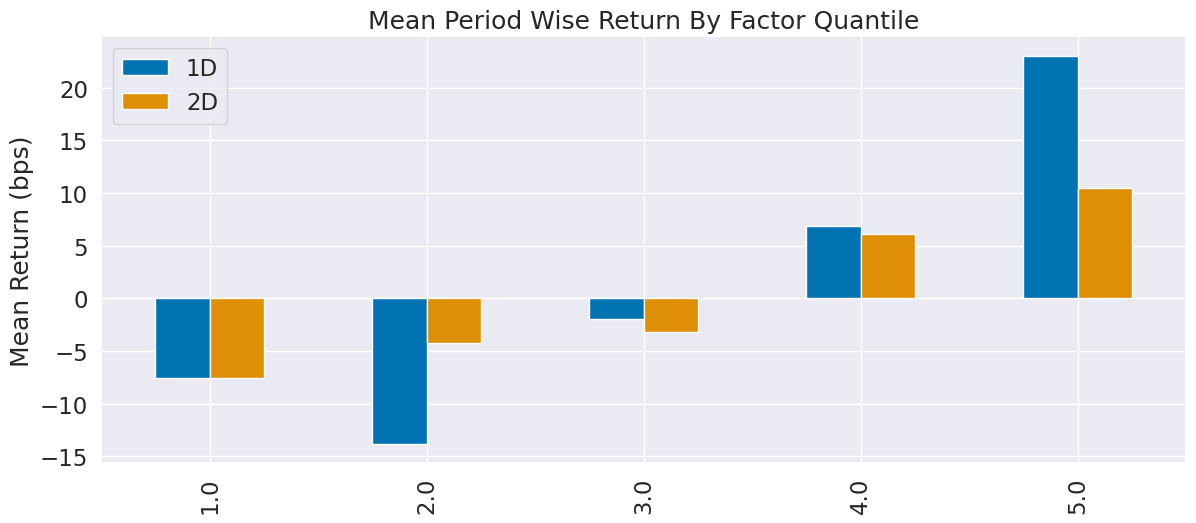

In [199]:
create_summary_tear_sheet(factor_data)

Quantiles Statistics


min       max      mean       std  count    count %
factor_quantile                                                          
1.0             -0.200730  0.283675  0.064801  0.073932    500  29.137529
2.0             -0.157213  0.293104  0.079427  0.071997    325  18.939394
3.0             -0.150638  0.299491  0.097367  0.074699    290  16.899767
4.0             -0.124605  0.311333  0.098693  0.074404    319  18.589744
5.0             -0.113453  0.331066  0.122582  0.075965    282  16.433566

Returns Analysis


1D      2D
Ann. alpha                                      0.407   0.237
beta                                            0.043  -0.004
Mean Period Wise Return Top Quantile (bps)     23.042  10.536
Mean Period Wise Return Bottom Quantile (bps)  -7.560  -7.537
Mean Period Wise Spread (bps)                  30.603  17.908

<Figure size 640x480 with 0 Axes>

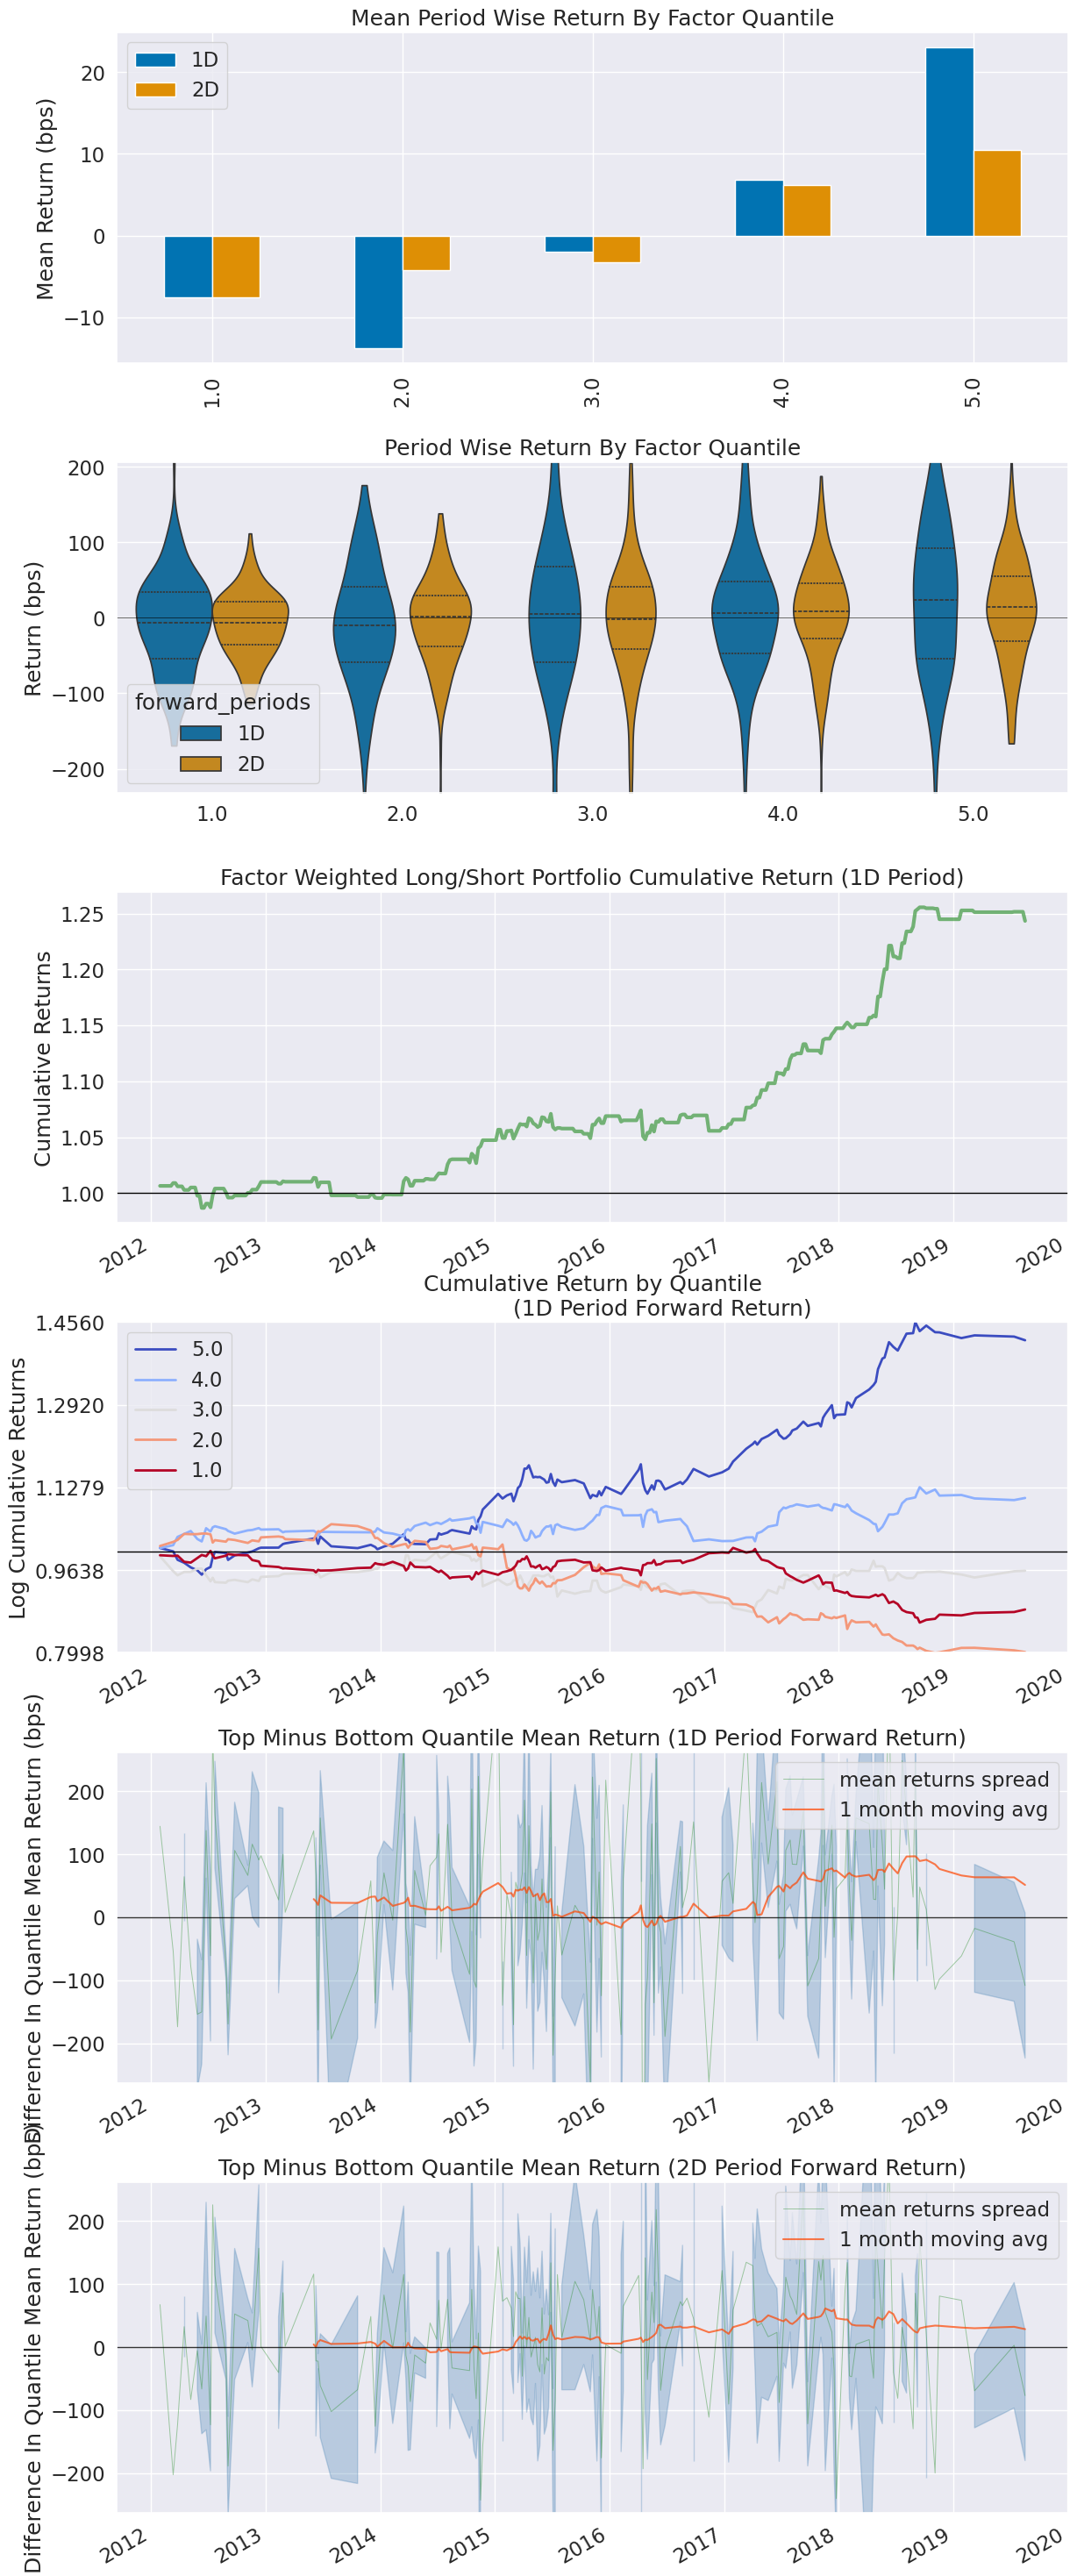

Information Analysis


1D     2D
IC Mean           0.089  0.075
IC Std.           0.358  0.321
Risk-Adjusted IC  0.249  0.235
t-stat(IC)          NaN    NaN
p-value(IC)         NaN    NaN
IC Skew             NaN    NaN
IC Kurtosis         NaN    NaN

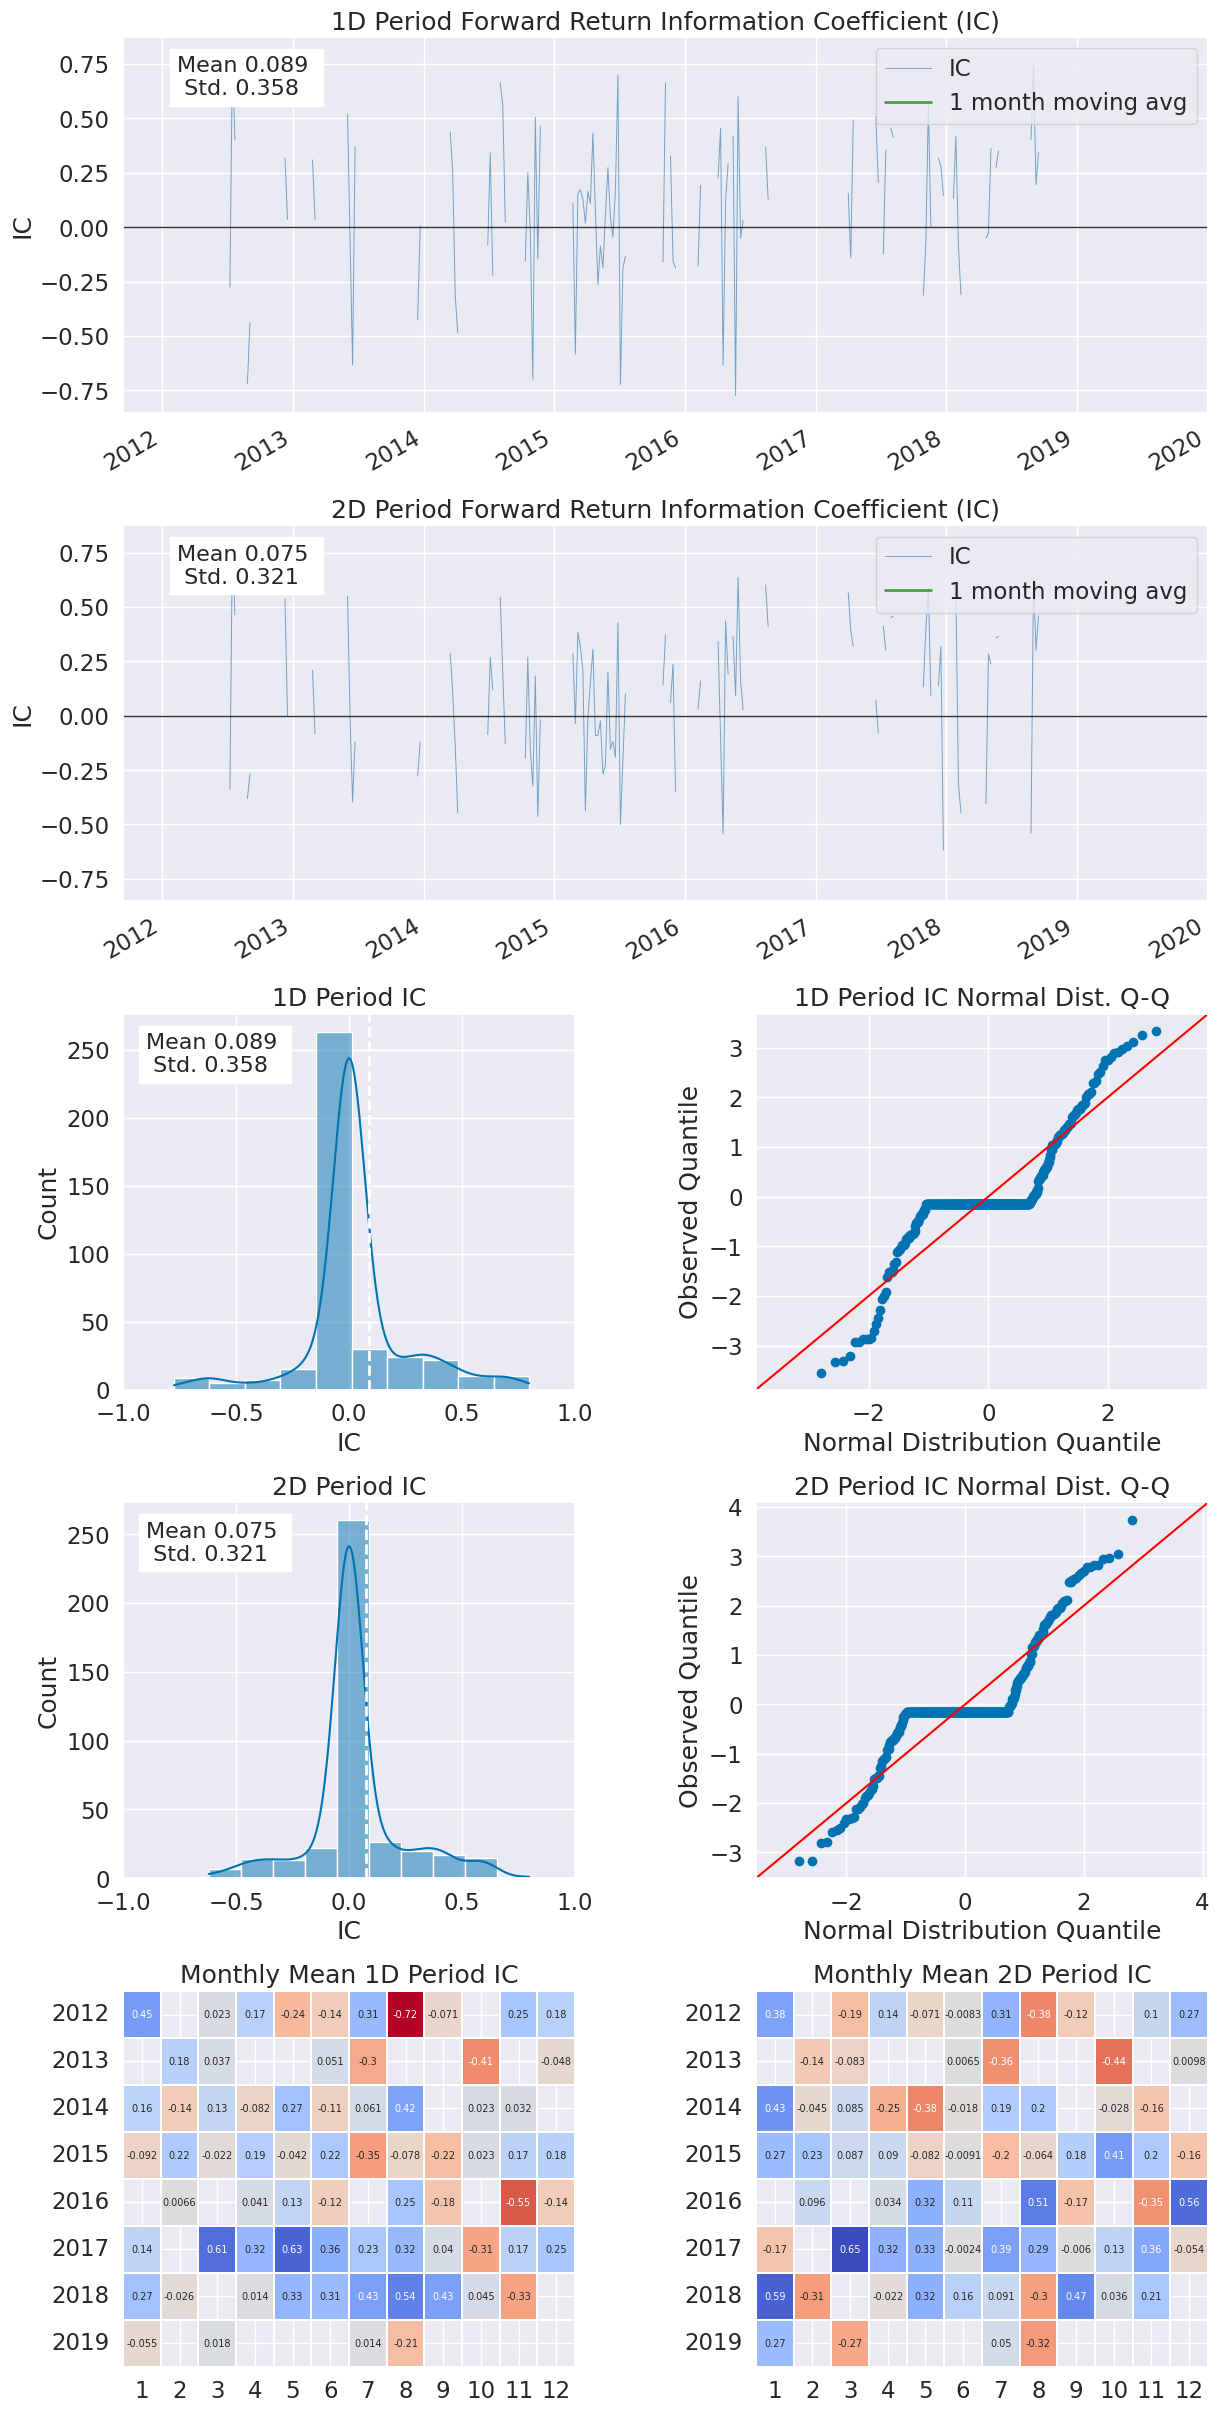

Turnover Analysis


1D     2D
Quantile 1.0 Mean Turnover   0.680  0.712
Quantile 2.0 Mean Turnover   0.799  0.878
Quantile 3.0 Mean Turnover   0.831  0.831
Quantile 4.0 Mean Turnover   0.802  0.800
Quantile 5.0 Mean Turnover   0.793  0.765

1D     2D
Mean Factor Rank Autocorrelation  0.095  0.087

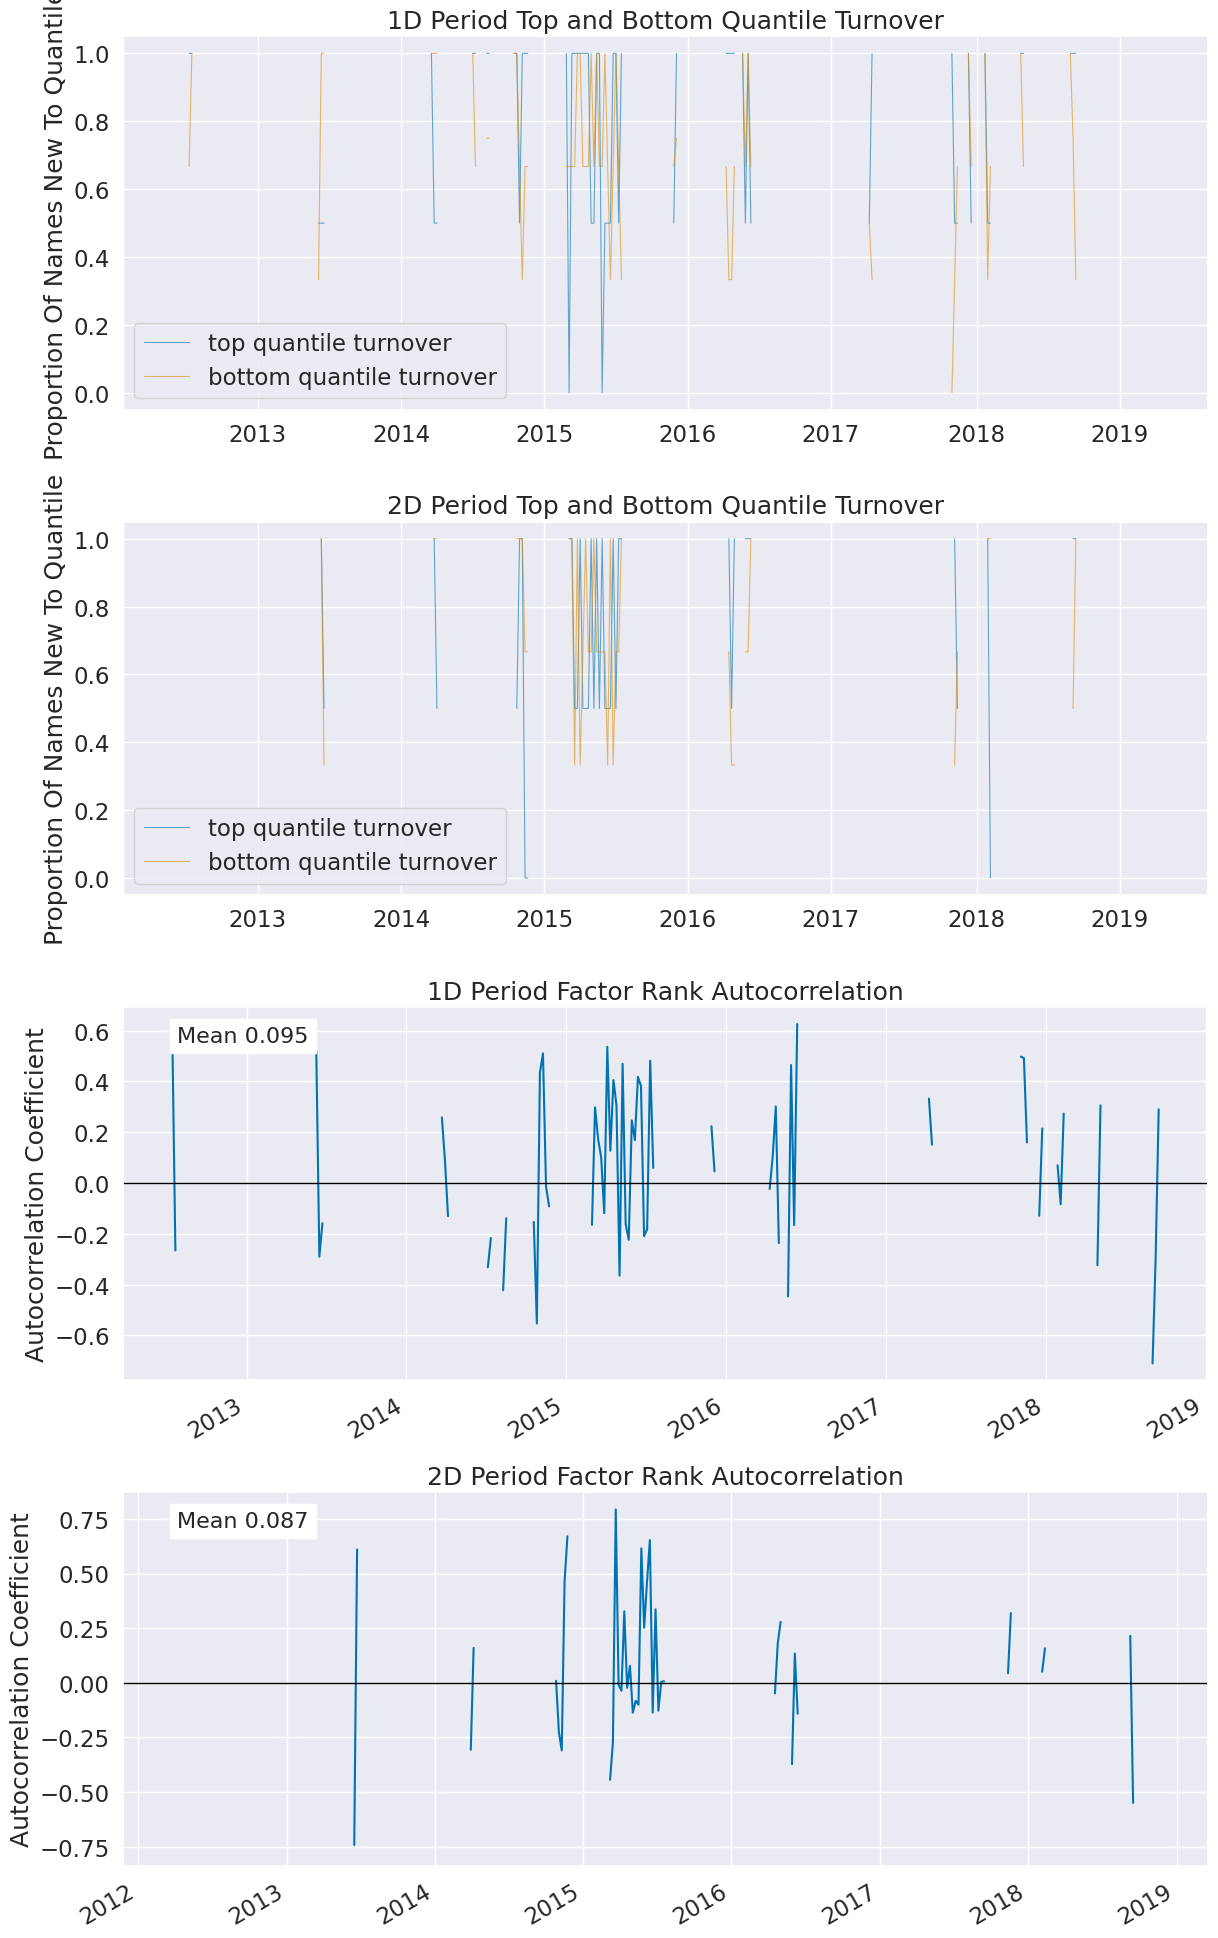

In [200]:
create_full_tear_sheet(factor_data)

### Random Forest

#### Select Parameters

In [201]:
# rf_daily_ic = pd.read_hdf('data/model_tuning.h5', 'rf/daily_ic')
# rf_daily_ic.info()

In [202]:
# def get_rf_params(data, t=5, best=0):
#     param_cols = scope_params[1:] + rf_train_params + ['boost_rounds']
#     df = data[data.lookahead==t].sort_values('ic', ascending=False).iloc[best]
#     return df.loc[param_cols]

In [203]:
# def get_rf_key(t, p):
#     key = f'{t}/{int(p.train_length)}/{int(p.test_length)}/{p.bagging_fraction}/'
#     return key + f'{p.feature_fraction}/{int(p.min_data_in_leaf)}/{int(p.max_depth)}'

In [204]:
# best_params_rf = get_rf_params(rf_daily_ic, t=1, best=0)
# best_params_rf

In [205]:
# best_params_rf.to_hdf('data.h5', 'best_params_rf')

#### Plot rolling IC

In [206]:
# def select_ic(params, ic_data, lookahead):
#     return ic_data.loc[(ic_data.lookahead == lookahead) &
#                        (ic_data.train_length == params.train_length) &
#                        (ic_data.test_length == params.test_length) &
#                        (ic_data.bagging_fraction == params.bagging_fraction) &
#                        (ic_data.feature_fraction == params.feature_fraction) &
#                        (ic_data.max_depth == params.max_depth) &
#                        (ic_data.boost_rounds == params.boost_rounds), ['date', 'ic']].set_index('date')

In [207]:
# fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 5))
# axes = axes.flatten()
# for i, t in enumerate([1]):#modificado para meses
#     params = get_rf_params(rf_daily_ic, t=t)
#     data = select_ic(params, rf_ic, lookahead=t).sort_index()
#     #rolling = data.rolling(63).ic.mean().dropna()
#     rolling = data.rolling(3*4).ic.mean().dropna()#semanas
#     avg = data.ic.mean()
#     med = data.ic.median()
#     rolling.plot(ax=axes[i], title=f'Horizon: {t} Day(s) | IC: Mean={avg*100:.2f}   Median={med*100:.2f}')
#     axes[i].axhline(avg, c='darkred', lw=1)
#     axes[i].axhline(0, ls='--', c='k', lw=1)

# fig.suptitle('3-Month Rolling Information Coefficient', fontsize=16)
# fig.tight_layout()
# fig.subplots_adjust(top=0.92);

#### Get Predictions for Validation Period

We retrieve the predictions for the 10 validation runs:

In [208]:
# lookahead = 1
# topn = 10
# for best in range(topn):
#     best_params = get_rf_params(rf_daily_ic, t=lookahead, best=best)
#     key = get_rf_key(lookahead, best_params)
#     rounds = str(int(best_params.boost_rounds))
#     if best == 0:
#         best_predictions = pd.read_hdf(results_path / 'tuning_rf.h5', 'predictions/' + key)
#         best_predictions = best_predictions[rounds].to_frame(best)
#     else:
#         best_predictions[best] = pd.read_hdf(results_path / 'tuning_rf.h5',
#                                              'predictions/' + key)[rounds]
# best_predictions = best_predictions.sort_index()

In [209]:
# key

In [210]:
# best_predictions.to_hdf('data/predictions.h5', f'rf/train/{lookahead:02}')
# best_predictions.info()

#### Get Trade Prices

Using next available prices. !! Esta parte del código no está revisada para una adaptacion mensual, no tomar como buena para conclusiones

In [211]:
test_tickers = best_predictions.index.get_level_values('ticker').unique()#modificado

In [212]:
trade_prices = get_trade_prices(test_tickers)
trade_prices.info()

open        high         low       close     volume  \
ticker date                                                                    
IYR    2000-01-03   19.267872   19.267872   18.455524   18.582453  1185699.0   
       2000-01-04   18.176279   18.201666   17.605097   17.770105   885705.0   
       2000-01-05   17.770105   17.960501   17.440088   17.630484   717181.0   
       2000-01-06   17.681255   18.518990   17.681255   18.404753   415832.0   
       2000-01-07   18.531681   18.734768   18.277822   18.709383   468149.0   
...                       ...         ...         ...         ...        ...   
XLY    2024-12-06  229.860001  232.850006  229.839996  232.800003  2444600.0   
       2024-12-09  234.139999  235.570007  231.229996  232.059998  3256900.0   
       2024-12-10  232.100006  234.600006  231.669998  232.440002  3815400.0   
       2024-12-11  234.369995  236.600006  234.240005  236.520004  2867400.0   
       2024-12-12  236.399994  236.660004  234.270004  234.559998  2433399.0   

                    Adj Close  
ticker date                    
IYR    2000-01-03   11.351279  
       2000-01-04   10.855049  
       2000-01-05   10.769757  
       2000-01-06   11.242723  
       2000-01-07   11.428815  
...                       ...  
XLY    2024-12-06  232.800003  
       2024-12-09  232.059998  
       2024-12-10  232.440002  
       2024-12-11  236.520004  
       2024-12-12  234.559998  

[69047 rows x 6 columns]

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 676 entries, 2012-01-08 00:00:00+00:00 to 2024-12-15 00:00:00+00:00
Freq: W-SUN
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   IYR     676 non-null    float64
 1   VOX     676 non-null    float64
 2   XLB     676 non-null    float64
 3   XLE     676 non-null    float64
 4   XLF     676 non-null    float64
 5   XLI     676 non-null    float64
 6   XLK     676 non-null    float64
 7   XLP     676 non-null    float64
 8   XLU     676 non-null    float64
 9   XLV     676 non-null    float64
 10  XLY     676 non-null    float64
dtypes: float64(11)
memory usage: 63.4 KB


In [213]:
# persist result in case we want to rerun:
trade_prices.to_hdf('data/model_tuning.h5', 'trade_prices/model_selection')
trade_prices = pd.read_hdf('data/model_tuning.h5', 'trade_prices/model_selection')

In [214]:
trade_prices = pd.read_hdf('data/model_tuning.h5', 'trade_prices/model_selection')

In [215]:
trade_prices

ticker                            IYR         VOX        XLB        XLE  \
date                                                                      
2012-01-08 00:00:00+00:00   56.930000   61.500000  34.820000  70.589996   
2012-01-15 00:00:00+00:00   58.220001   63.160000  36.540001  70.220001   
2012-01-22 00:00:00+00:00   59.119999   63.180000  36.639999  71.629997   
2012-01-29 00:00:00+00:00   60.259998   61.320000  36.619999  70.660004   
2012-02-05 00:00:00+00:00   61.880001   63.310001  37.599998  72.360001   
...                               ...         ...        ...        ...   
2024-11-17 00:00:00+00:00   97.389999  151.139999  91.449997  95.480003   
2024-11-24 00:00:00+00:00  100.940002  153.770004  94.470001  97.250000   
2024-12-01 00:00:00+00:00  101.849998  155.529999  94.879997  95.500000   
2024-12-08 00:00:00+00:00   99.820000  161.000000  92.639999  91.779999   
2024-12-15 00:00:00+00:00   98.019997  163.550003  90.309998  90.239998   

ticker                           XLF         XLI         XLK        XLP  \
date                                                                      
2012-01-08 00:00:00+00:00  10.926076   34.689999   26.059999  32.240002   
2012-01-15 00:00:00+00:00  11.234768   35.970001   26.260000  32.410000   
2012-01-22 00:00:00+00:00  11.494720   36.099998   26.840000  32.310001   
2012-01-29 00:00:00+00:00  11.348497   36.130001   26.670000  32.080002   
2012-02-05 00:00:00+00:00  11.900894   37.000000   27.639999  32.410000   
...                              ...         ...         ...        ...   
2024-11-17 00:00:00+00:00  49.910000  139.089996  228.710007  80.139999   
2024-11-24 00:00:00+00:00  51.009998  143.380005  235.360001  82.379997   
2024-12-01 00:00:00+00:00  51.419998  143.899994  233.899994  83.139999   
2024-12-08 00:00:00+00:00  50.439999  140.589996  239.940002  82.500000   
2024-12-15 00:00:00+00:00  49.930000  138.750000  237.839996  82.529999   

ticker                           XLU         XLV         XLY  
date                                                          
2012-01-08 00:00:00+00:00  35.130001   35.200001   40.160000  
2012-01-15 00:00:00+00:00  35.090000   35.709999   40.610001  
2012-01-22 00:00:00+00:00  34.560001   35.860001   41.169998  
2012-01-29 00:00:00+00:00  34.599998   35.599998   41.090000  
2012-02-05 00:00:00+00:00  34.779999   36.060001   41.990002  
...                              ...         ...         ...  
2024-11-17 00:00:00+00:00  79.180000  141.470001  216.009995  
2024-11-24 00:00:00+00:00  82.099998  144.809998  220.699997  
2024-12-01 00:00:00+00:00  82.919998  147.320007  223.869995  
2024-12-08 00:00:00+00:00  79.690002  144.419998  234.139999  
2024-12-15 00:00:00+00:00  78.000000  142.169998  236.399994  

[676 rows x 11 columns]

We average the top five models and provide the corresponding prices to Alphalens, in order to compute the mean period-wise return earned on an equal-weighted portfolio invested in the daily factor quintiles for various holding periods:

In [216]:
factor = best_predictions.iloc[:, :5].mean(1).dropna().tz_localize('UTC', level='date').swaplevel()

In [217]:
best_predictions.iloc[:, :5]

0         1         2         3         4
ticker date                                                        
IYR    2011-01-16  0.091634  0.139810  0.140270 -0.041411 -0.119032
       2011-01-23  0.042133  0.043969  0.096669  0.262673  0.170665
       2011-01-30  0.035764  0.037370  0.087289  0.009475  0.117571
       2011-02-06  0.040504  0.036432  0.075968 -0.133762 -0.159102
       2011-02-13  0.046401  0.043112  0.088899 -0.157749 -0.162323
...                     ...       ...       ...       ...       ...
XLY    2019-12-01  0.086268  0.083759  0.043596 -0.079512 -0.110340
       2019-12-08  0.085466  0.082867  0.065725 -0.047938  0.152611
       2019-12-15  0.086361  0.080639  0.074397  0.097582  0.090131
       2019-12-22  0.087736  0.083697  0.060979  0.072073 -0.036395
       2019-12-29  0.085536  0.082900  0.068404  0.036571  0.098718

[5148 rows x 5 columns]

In [218]:
factor.tail()

date                       ticker
2019-12-01 00:00:00+00:00  XLY       0.004754
2019-12-08 00:00:00+00:00  XLY       0.067746
2019-12-15 00:00:00+00:00  XLY       0.085822
2019-12-22 00:00:00+00:00  XLY       0.053618
2019-12-29 00:00:00+00:00  XLY       0.074426
dtype: float64

In [219]:
#trade_prices= trade_prices.asfreq('W')

In [220]:
freq = pd.infer_freq(trade_prices.index)
print(freq)

W-SUN


#### Create AlphaLens Inputs

In [221]:
factor_data = get_clean_factor_and_forward_returns(factor=factor,
                                                   prices=trade_prices,
                                                   quantiles=5,
                                                   periods=(1, 2),max_loss=2)#modificado

Dropped 66.7% entries from factor data: 10.9% in forward returns computation and 55.8% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 200.0%, not exceeded: OK!


#### Compute Alphalens metrics

In [222]:
mean_quant_ret_bydate, std_quant_daily = perf.mean_return_by_quantile(
    factor_data,
    by_date=True,
    by_group=False,
    demeaned=True,
    group_adjust=False,
)

In [223]:
factor_returns = perf.factor_returns(factor_data)

In [224]:
mean_quant_ret, std_quantile = perf.mean_return_by_quantile(factor_data,
                                                            by_group=False,
                                                            demeaned=True)



mean_quant_rateret = mean_quant_ret.apply(rate_of_return, axis=0,
                                          base_period=mean_quant_ret.columns[0])

In [225]:
mean_quant_ret_bydate, std_quant_daily = perf.mean_return_by_quantile(
    factor_data,
    by_date=True,
    by_group=False,
    demeaned=True,
    group_adjust=False,
)

mean_quant_rateret_bydate = mean_quant_ret_bydate.apply(
    rate_of_return,
    base_period=mean_quant_ret_bydate.columns[0],
)

compstd_quant_daily = std_quant_daily.apply(std_conversion,
                                            base_period=std_quant_daily.columns[0])

alpha_beta = perf.factor_alpha_beta(factor_data,
                                    demeaned=True)

mean_ret_spread_quant, std_spread_quant = perf.compute_mean_returns_spread(
    mean_quant_rateret_bydate,
    factor_data["factor_quantile"].max(),
    factor_data["factor_quantile"].min(),
    std_err=compstd_quant_daily,
)

In [226]:
mean_ret_spread_quant.mean().mul(10000).to_frame('Mean Period Wise Spread (bps)').join(alpha_beta.T).T

1D         2D
Mean Period Wise Spread (bps)  30.602520  17.908110
Ann. alpha                      0.407483   0.236533
beta                            0.042618  -0.003893

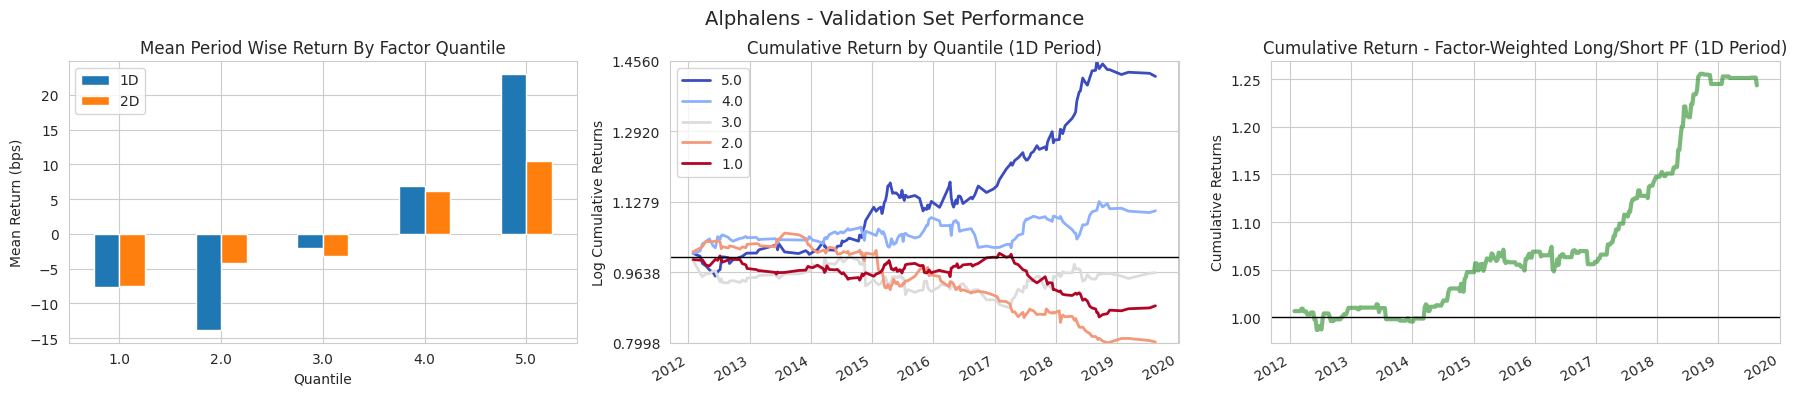

In [227]:
fig, axes = plt.subplots(ncols=3, figsize=(18, 4))


plotting.plot_quantile_returns_bar(mean_quant_rateret, ax=axes[0])
plt.setp(axes[0].xaxis.get_majorticklabels(), rotation=0)
axes[0].set_xlabel('Quantile')

plotting.plot_cumulative_returns_by_quantile(mean_quant_ret_bydate['1D'],
                                             freq=pd.tseries.offsets.BDay(),
                                             period='1D',
                                             ax=axes[1])
axes[1].set_title('Cumulative Return by Quantile (1D Period)')

title = "Cumulative Return - Factor-Weighted Long/Short PF (1D Period)"
plotting.plot_cumulative_returns(factor_returns['1D'],
                                 period='1D',
                                 freq=pd.tseries.offsets.BDay(),
                                 title=title,
                                 ax=axes[2])

fig.suptitle('Alphalens - Validation Set Performance', fontsize=14)
fig.tight_layout()
fig.subplots_adjust(top=.85);

In [228]:
factor_data

1D        2D    factor  factor_quantile
date                      asset                                               
2012-01-29 00:00:00+00:00 IYR    0.026884  0.016927 -0.092846              1.0
2012-03-11 00:00:00+00:00 IYR    0.026259  0.019818  0.031585              4.0
2012-03-25 00:00:00+00:00 IYR    0.008097 -0.017004  0.103981              1.0
2012-04-15 00:00:00+00:00 IYR    0.012066  0.041741 -0.097352              3.0
2012-05-06 00:00:00+00:00 IYR   -0.001732 -0.057462 -0.072255              2.0
...                                   ...       ...       ...              ...
2018-11-18 00:00:00+00:00 XLY   -0.026480  0.038541  0.168702              3.0
2019-01-27 00:00:00+00:00 XLY    0.010002  0.014248  0.003125              1.0
2019-03-10 00:00:00+00:00 XLY    0.017191  0.024361  0.243654              4.0
2019-07-14 00:00:00+00:00 XLY   -0.015923 -0.008926  0.110881              1.0
2019-08-18 00:00:00+00:00 XLY   -0.000936  0.013023  0.058668              3.0

[1716 rows x 4 columns]

#### Summary Tearsheet

Quantiles Statistics


min       max      mean       std  count    count %
factor_quantile                                                          
1.0             -0.200730  0.283675  0.064801  0.073932    500  29.137529
2.0             -0.157213  0.293104  0.079427  0.071997    325  18.939394
3.0             -0.150638  0.299491  0.097367  0.074699    290  16.899767
4.0             -0.124605  0.311333  0.098693  0.074404    319  18.589744
5.0             -0.113453  0.331066  0.122582  0.075965    282  16.433566

Returns Analysis


1D      2D
Ann. alpha                                      0.407   0.237
beta                                            0.043  -0.004
Mean Period Wise Return Top Quantile (bps)     23.042  10.536
Mean Period Wise Return Bottom Quantile (bps)  -7.560  -7.537
Mean Period Wise Spread (bps)                  30.603  17.908

Information Analysis


1D     2D
IC Mean           0.089  0.075
IC Std.           0.358  0.321
Risk-Adjusted IC  0.249  0.235
t-stat(IC)          NaN    NaN
p-value(IC)         NaN    NaN
IC Skew             NaN    NaN
IC Kurtosis         NaN    NaN

Turnover Analysis


1D     2D
Quantile 1 Mean Turnover   0.680  0.712
Quantile 2 Mean Turnover   0.799  0.878
Quantile 3 Mean Turnover   0.831  0.831
Quantile 4 Mean Turnover   0.802  0.800
Quantile 5 Mean Turnover   0.793  0.765

1D     2D
Mean Factor Rank Autocorrelation  0.095  0.087

<Figure size 640x480 with 0 Axes>

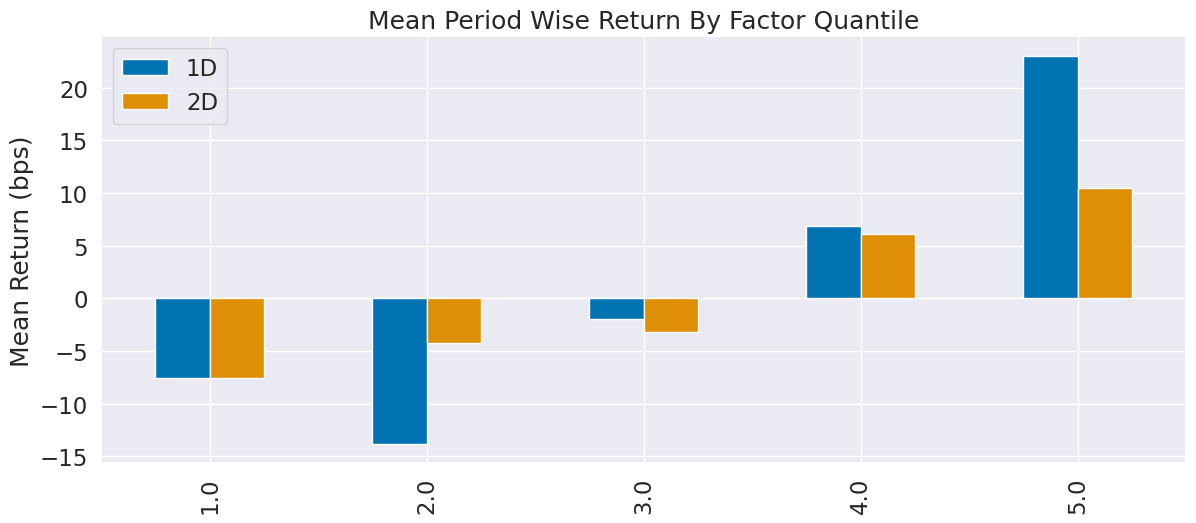

In [229]:
create_summary_tear_sheet(factor_data)

Quantiles Statistics


min       max      mean       std  count    count %
factor_quantile                                                          
1.0             -0.200730  0.283675  0.064801  0.073932    500  29.137529
2.0             -0.157213  0.293104  0.079427  0.071997    325  18.939394
3.0             -0.150638  0.299491  0.097367  0.074699    290  16.899767
4.0             -0.124605  0.311333  0.098693  0.074404    319  18.589744
5.0             -0.113453  0.331066  0.122582  0.075965    282  16.433566

Returns Analysis


1D      2D
Ann. alpha                                      0.407   0.237
beta                                            0.043  -0.004
Mean Period Wise Return Top Quantile (bps)     23.042  10.536
Mean Period Wise Return Bottom Quantile (bps)  -7.560  -7.537
Mean Period Wise Spread (bps)                  30.603  17.908

<Figure size 640x480 with 0 Axes>

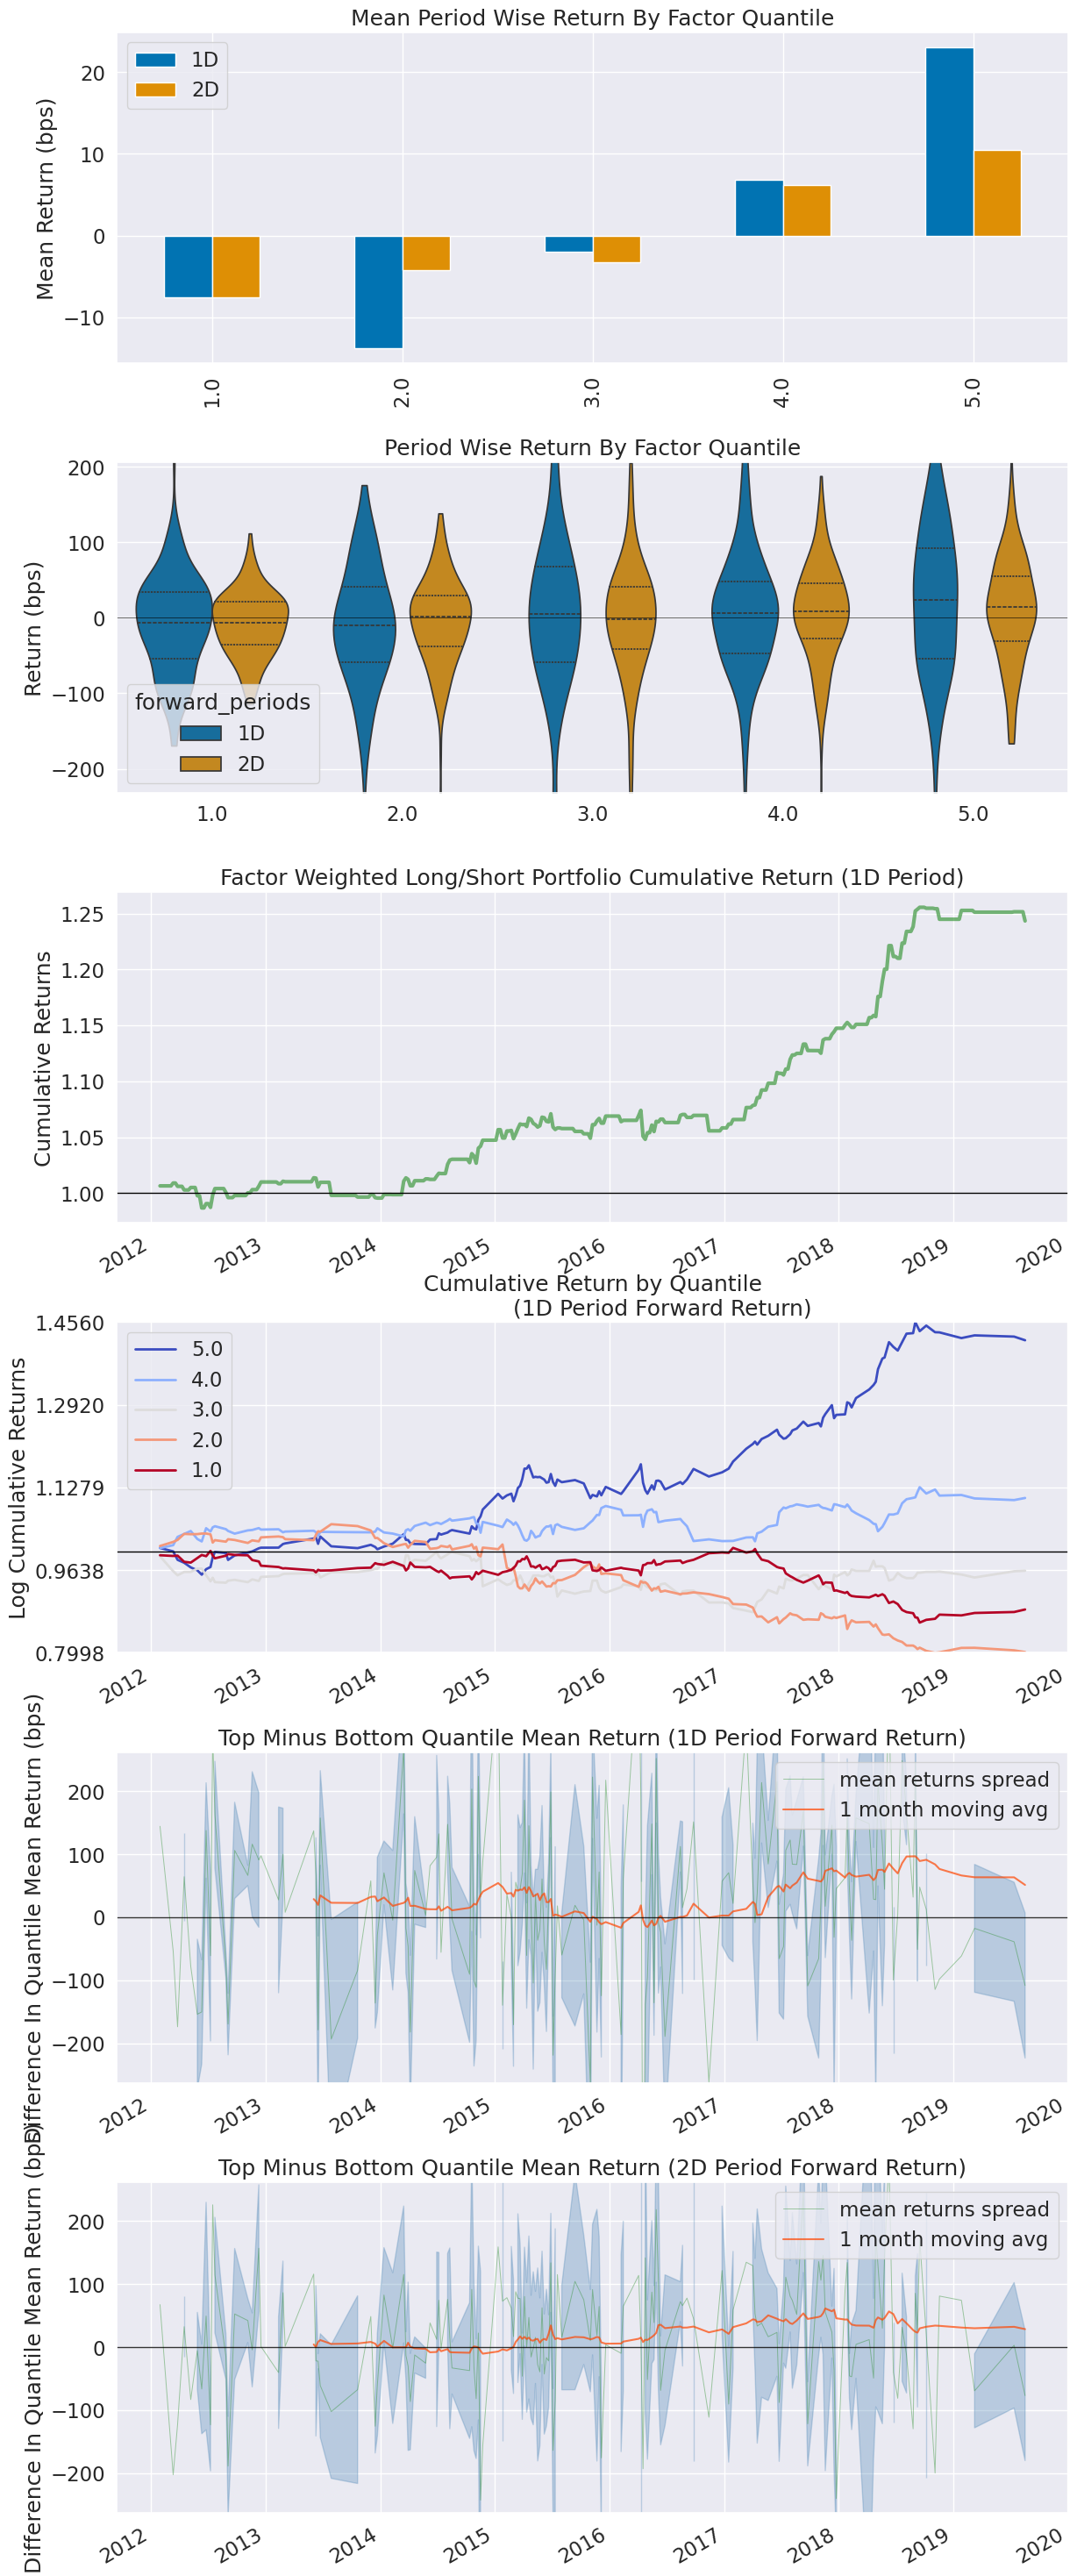

Information Analysis


1D     2D
IC Mean           0.089  0.075
IC Std.           0.358  0.321
Risk-Adjusted IC  0.249  0.235
t-stat(IC)          NaN    NaN
p-value(IC)         NaN    NaN
IC Skew             NaN    NaN
IC Kurtosis         NaN    NaN

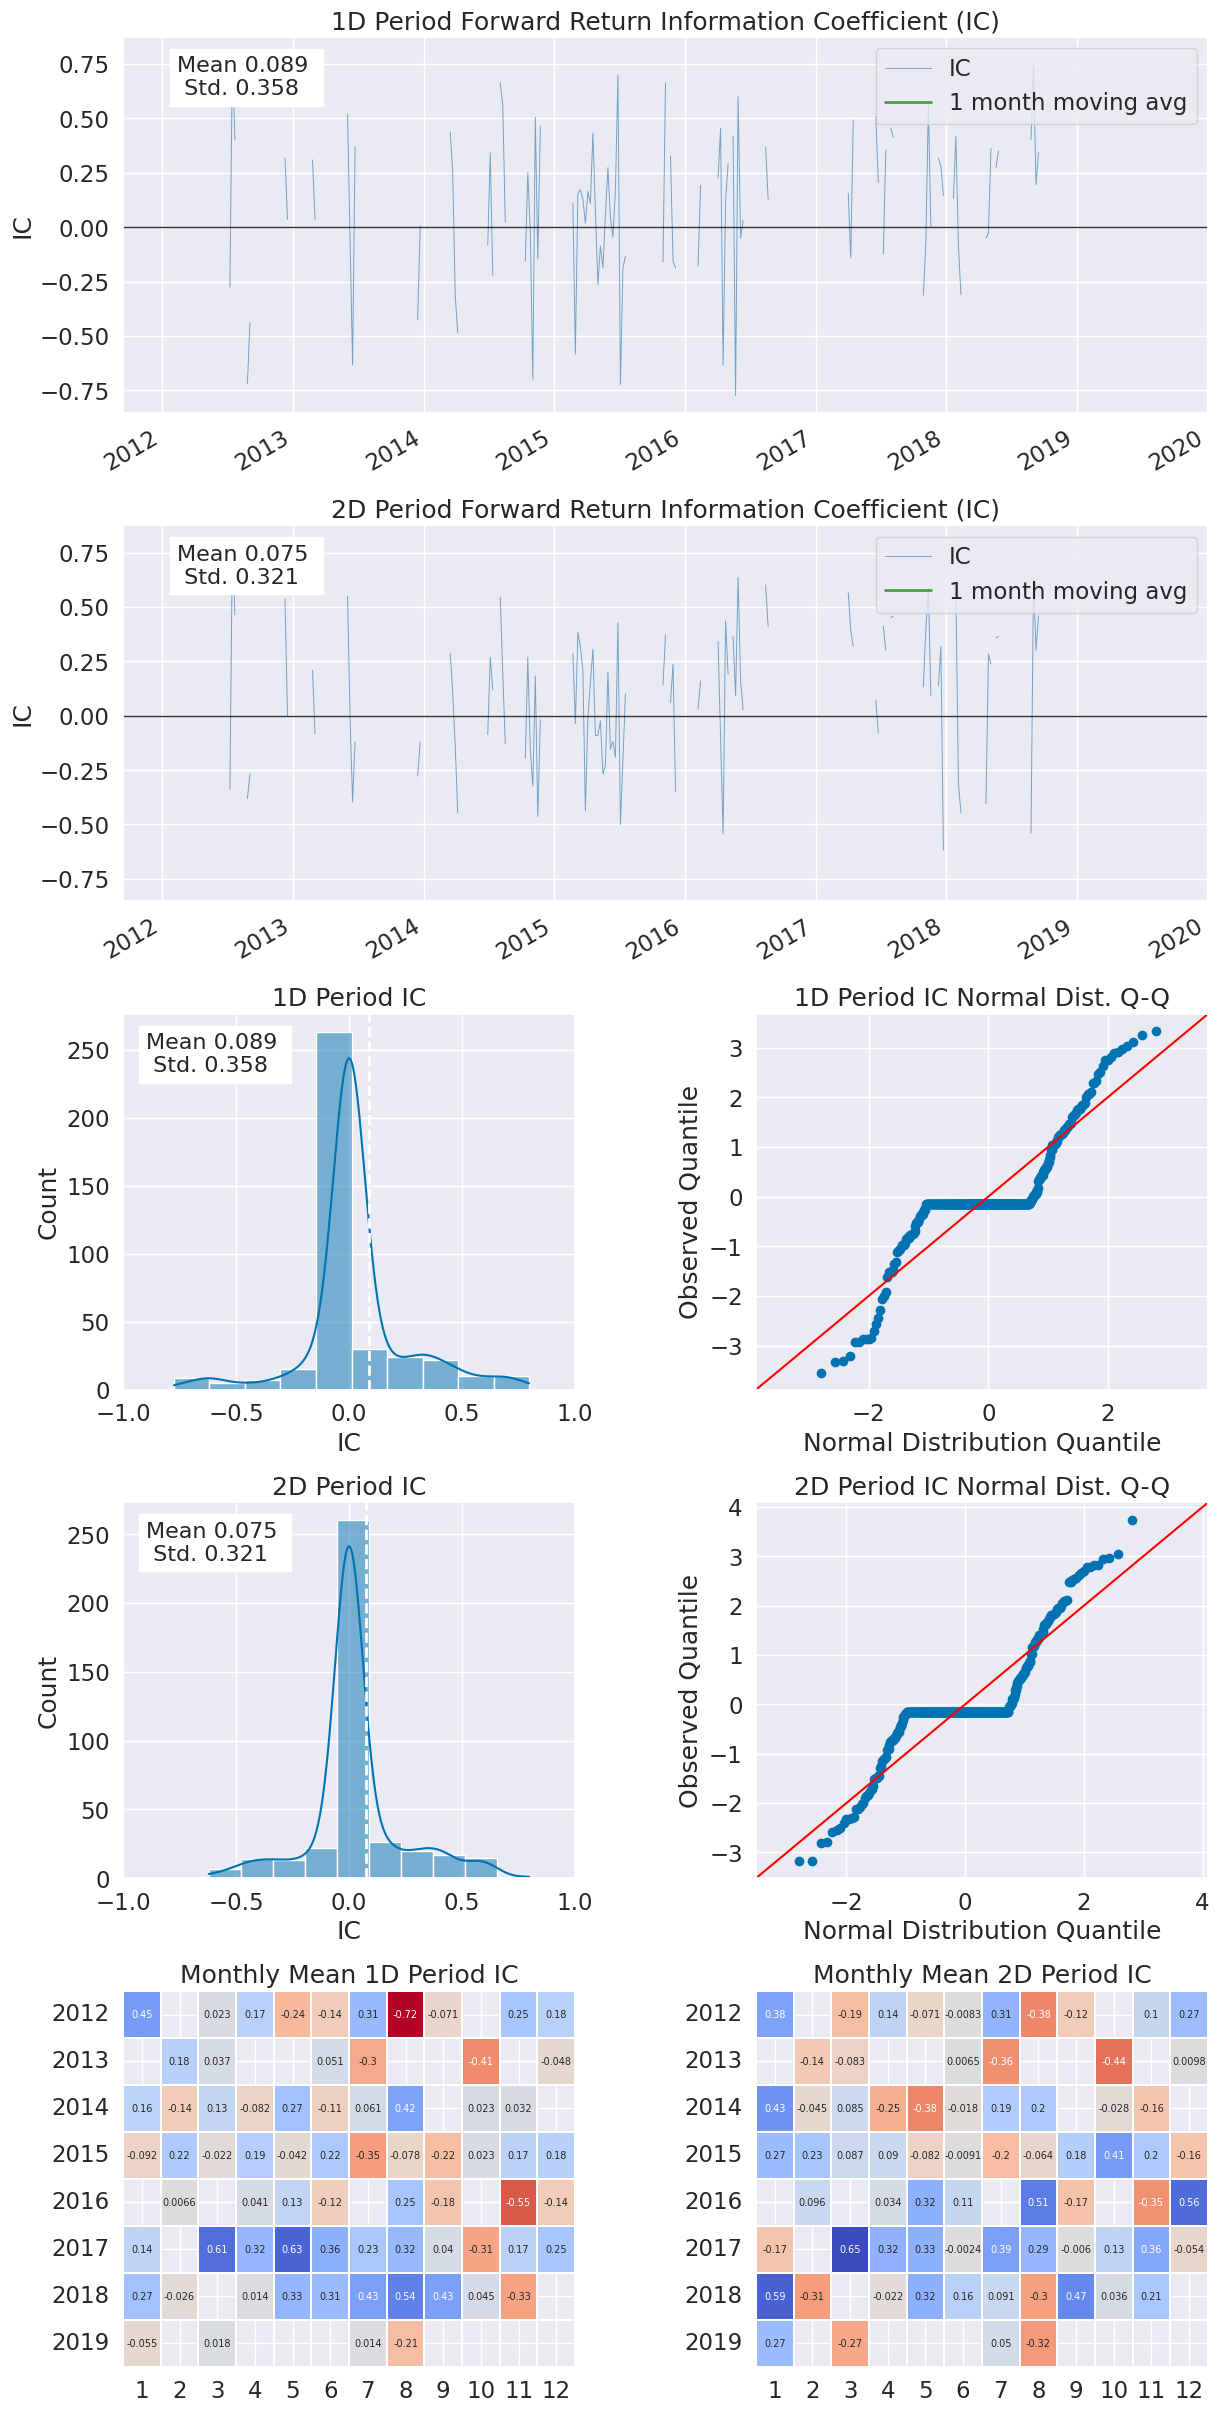

Turnover Analysis


1D     2D
Quantile 1.0 Mean Turnover   0.680  0.712
Quantile 2.0 Mean Turnover   0.799  0.878
Quantile 3.0 Mean Turnover   0.831  0.831
Quantile 4.0 Mean Turnover   0.802  0.800
Quantile 5.0 Mean Turnover   0.793  0.765

1D     2D
Mean Factor Rank Autocorrelation  0.095  0.087

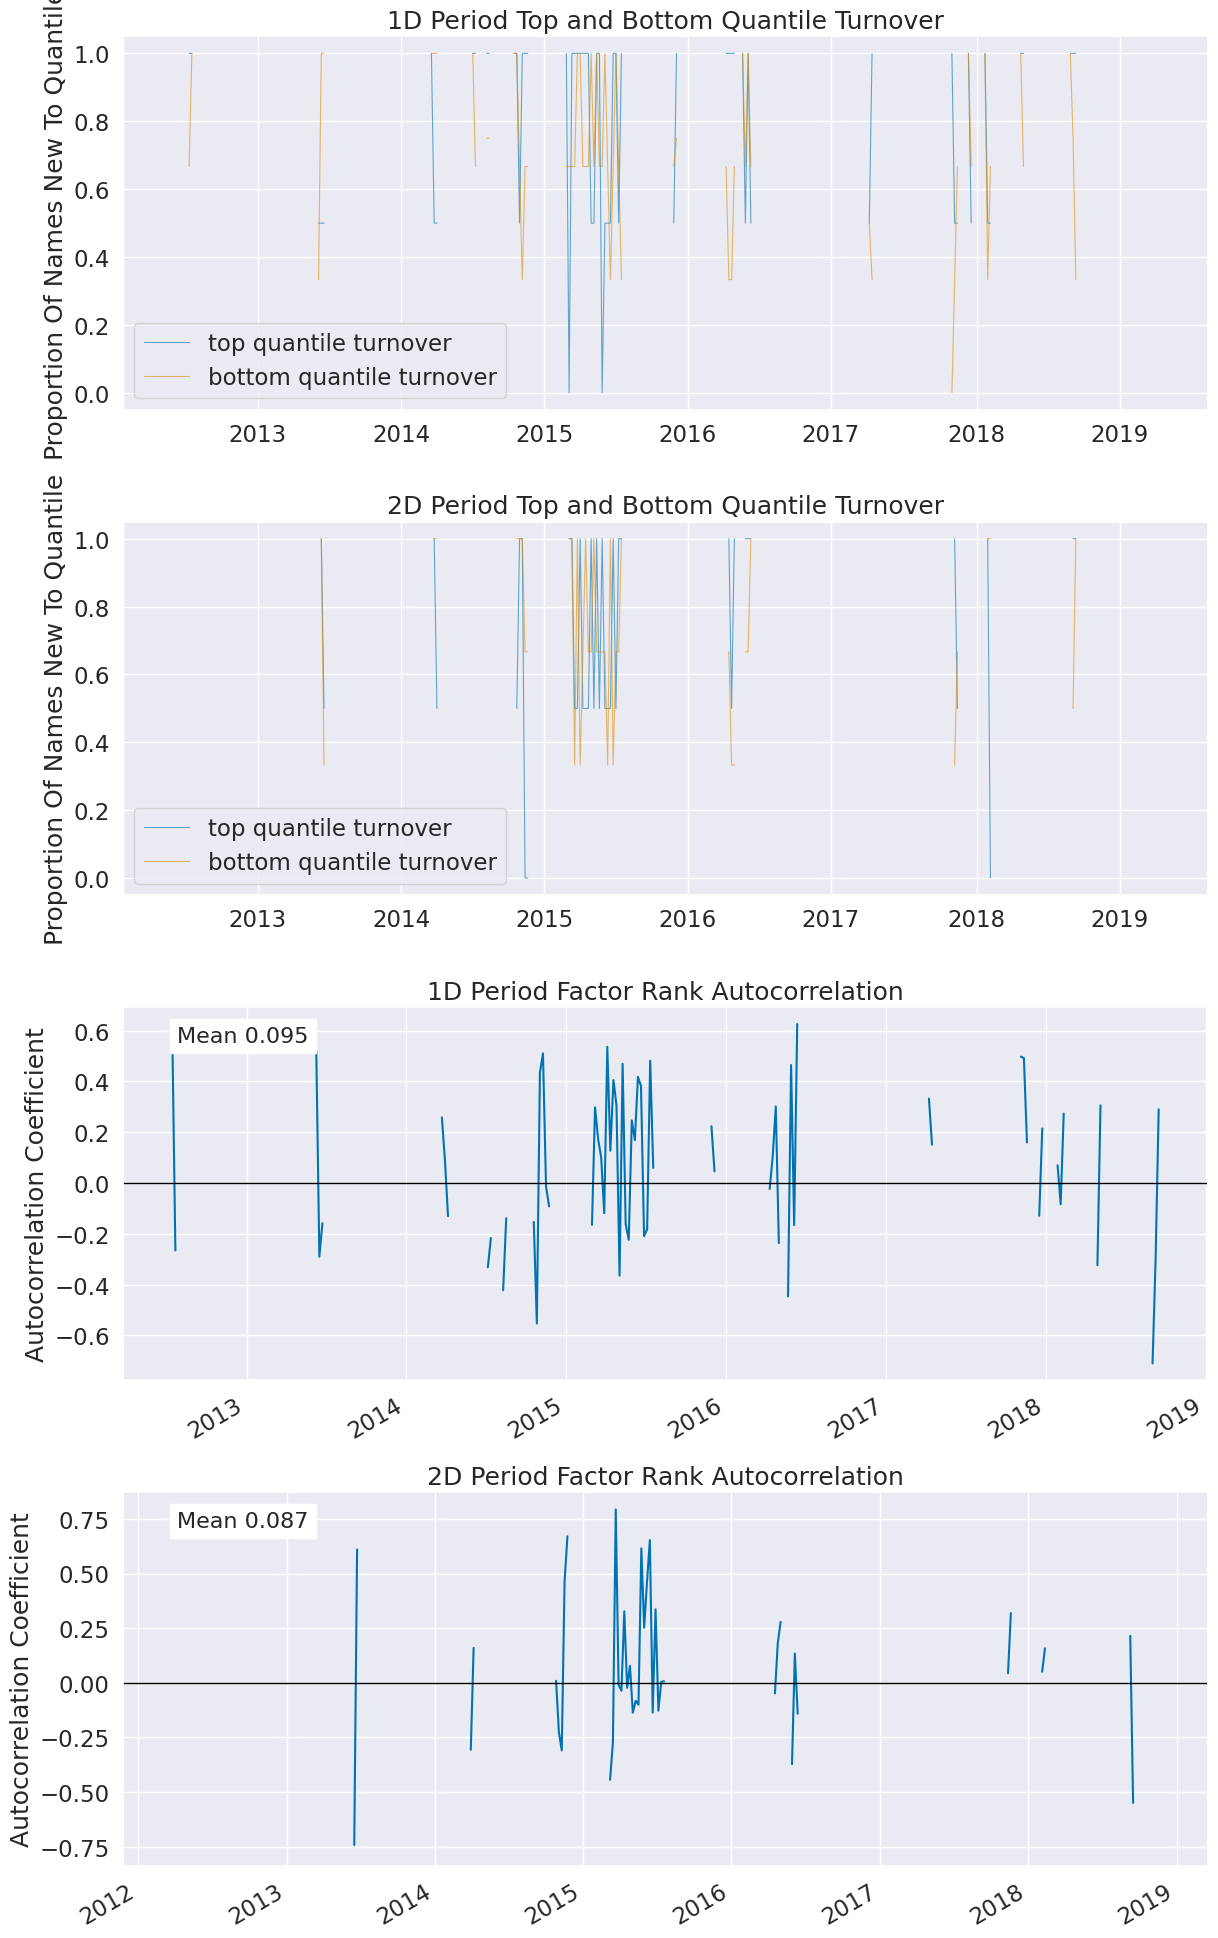

In [230]:
create_full_tear_sheet(factor_data)